In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
GOOGLE_COLAB = True

In [0]:
%reload_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [6]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.0MB/s 


In [7]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [0]:
import sys
if GOOGLE_COLAB:
    sys.path.append('drive/My Drive/yelp_sentiment_analysis')
else:
    sys.path.append('../')

from yelpsent import data
from yelpsent import features
from yelpsent import metrics
from yelpsent import visualization
from yelpsent import models

In [0]:
import importlib
def reload():
  importlib.reload(data)
  importlib.reload(features)
  importlib.reload(metrics)
  importlib.reload(visualization)
  importlib.reload(models)

# Load Dataset

In [0]:
if GOOGLE_COLAB:
    data_train, data_test = data.load_dataset("drive/My Drive/yelp_sentiment_analysis/data/yelp_train_clean_nolemma.json",
                                              "drive/My Drive/yelp_sentiment_analysis/data/yelp_test_clean_nolemma.json")
else:
    data_train, data_test = data.load_dataset("../data/yelp_train.json",
                                              "../data/yelp_test.json")

In [0]:
X_train = data_train['review'].tolist()
y_train = data_train['sentiment'].tolist()

In [0]:
X_test = data_test['review'].tolist()
y_test = data_test['sentiment'].tolist()

In [13]:
# Set the output directory for saving model file
OUTPUT_DIR = 'bert'

DO_DELETE = True

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: bert *****


In [14]:
data_train.head()

,review,sentiment
0,may 9 2015 party of six with reservations for ...,0
1,there was nothing good to say there i said it ...,0
2,went there with my friend ordered veal tartare...,0
3,service 2 5 waiter forgot drinks and did revis...,0
4,not great we were expecting a phenomenal burge...,0


In [0]:
DATA_COLUMN = 'review'
LABEL_COLUMN = 'sentiment'
# The list containing all the classes (train['SECTION'].unique())
label_list = [0, 1, 2]

# Preprocessing

In [0]:
train_InputExamples = data_train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                                  text_a = x[DATA_COLUMN], 
                                                                                  text_b = None,
                                                                                  label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = data_test.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                               text_a = x[DATA_COLUMN],
                                                                               text_b = None,
                                                                               label = x[LABEL_COLUMN]), axis = 1)

In [17]:
train_InputExamples

0         <bert.run_classifier.InputExample object at 0x...
1         <bert.run_classifier.InputExample object at 0x...
2         <bert.run_classifier.InputExample object at 0x...
3         <bert.run_classifier.InputExample object at 0x...
4         <bert.run_classifier.InputExample object at 0x...
                                ...                        
134995    <bert.run_classifier.InputExample object at 0x...
134996    <bert.run_classifier.InputExample object at 0x...
134997    <bert.run_classifier.InputExample object at 0x...
134998    <bert.run_classifier.InputExample object at 0x...
134999    <bert.run_classifier.InputExample object at 0x...
Length: 135000, dtype: object

In [18]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  may 9 2015 party of six with reservations for 8 30 pm and needed to be finished by 10 15 pm for a birthday interactive event arrived on time waited 35 mins for drink orders never asked for a second order which at the time we also placed are complete food orders one app of caesar salad and and mussels and basic pizza simple pasta entrees by each of us drinks arrived 20 minutes later with an olive and bread board as an apology never been to an italian restaurant where bread olives are an apology but rather a standard staple at 9 30 pm i asked would are food be showing up soon or shall we be stuck just doing take out and eat in our car answer we will try and get it out by 10 00 pm that would give us 15 minutes to chow done our dinner at 9 45 pm the owner server bartender said our entrees would not be ready before 10 00 pm and would we would like some quick appetizers so we would not go hungry to our interac

In [19]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [20]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['may', '9', '2015', 'party', 'of', 'six', 'with', 'reservations', 'for', '8', '30', 'pm', 'and', 'needed', 'to', 'be', 'finished', 'by', '10', '15', 'pm', 'for', 'a', 'birthday', 'interactive', 'event', 'arrived', 'on', 'time', 'waited', '35', 'min', '##s', 'for', 'drink', 'orders', 'never', 'asked', 'for', 'a', 'second', 'order', 'which', 'at', 'the', 'time', 'we', 'also', 'placed', 'are', 'complete', 'food', 'orders', 'one', 'app', 'of', 'caesar', 'salad', 'and', 'and', 'mu', '##ssel', '##s', 'and', 'basic', 'pizza', 'simple', 'pasta', 'en', '##tree', '##s', 'by', 'each', 'of', 'us', 'drinks', 'arrived', '20', 'minutes', 'later', 'with', 'an', 'olive', 'and', 'bread', 'board', 'as', 'an', 'apology', 'never', 'been', 'to', 'an', 'italian', 'restaurant', 'where', 'bread', 'olive', '##s', 'are', 'an', 'apology', 'but', 'rather', 'a', 'standard', 'staple', 'at', '9', '30', 'pm', 'i', 'asked', 'would', 'are', 'food', 'be', 'showing', 'up', 'soon', 'or', 'shall', 'we', 'be', 'stuck', 'jus

In [21]:
# We'll set sequences to be at most 350 tokens long.
MAX_SEQ_LENGTH = 350

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 135000


INFO:tensorflow:Writing example 0 of 135000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] may 9 2015 party of six with reservations for 8 30 pm and needed to be finished by 10 15 pm for a birthday interactive event arrived on time waited 35 min ##s for drink orders never asked for a second order which at the time we also placed are complete food orders one app of caesar salad and and mu ##ssel ##s and basic pizza simple pasta en ##tree ##s by each of us drinks arrived 20 minutes later with an olive and bread board as an apology never been to an italian restaurant where bread olive ##s are an apology but rather a standard staple at 9 30 pm i asked would are food be showing up soon or shall we be stuck just doing take out and eat in our car answer we will try and get it out by 10 00 pm that would give us 15 minutes to chow done our dinner at 9 45 pm the owner server bartender said our en ##tree ##s would not be ready before 10 00 pm and would we would like some quick app ##eti ##zers so we would not go hungry to our interactive event well serious

INFO:tensorflow:tokens: [CLS] may 9 2015 party of six with reservations for 8 30 pm and needed to be finished by 10 15 pm for a birthday interactive event arrived on time waited 35 min ##s for drink orders never asked for a second order which at the time we also placed are complete food orders one app of caesar salad and and mu ##ssel ##s and basic pizza simple pasta en ##tree ##s by each of us drinks arrived 20 minutes later with an olive and bread board as an apology never been to an italian restaurant where bread olive ##s are an apology but rather a standard staple at 9 30 pm i asked would are food be showing up soon or shall we be stuck just doing take out and eat in our car answer we will try and get it out by 10 00 pm that would give us 15 minutes to chow done our dinner at 9 45 pm the owner server bartender said our en ##tree ##s would not be ready before 10 00 pm and would we would like some quick app ##eti ##zers so we would not go hungry to our interactive event well serious

INFO:tensorflow:input_ids: 101 2089 1023 2325 2283 1997 2416 2007 17829 2005 1022 2382 7610 1998 2734 2000 2022 2736 2011 2184 2321 7610 2005 1037 5798 9123 2724 3369 2006 2051 4741 3486 8117 2015 2005 4392 4449 2196 2356 2005 1037 2117 2344 2029 2012 1996 2051 2057 2036 2872 2024 3143 2833 4449 2028 10439 1997 11604 16521 1998 1998 14163 21218 2015 1998 3937 10733 3722 24857 4372 13334 2015 2011 2169 1997 2149 8974 3369 2322 2781 2101 2007 2019 9724 1998 7852 2604 2004 2019 12480 2196 2042 2000 2019 3059 4825 2073 7852 9724 2015 2024 2019 12480 2021 2738 1037 3115 18785 2012 1023 2382 7610 1045 2356 2052 2024 2833 2022 4760 2039 2574 2030 4618 2057 2022 5881 2074 2725 2202 2041 1998 4521 1999 2256 2482 3437 2057 2097 3046 1998 2131 2009 2041 2011 2184 4002 7610 2008 2052 2507 2149 2321 2781 2000 20209 2589 2256 4596 2012 1023 3429 7610 1996 3954 8241 15812 2056 2256 4372 13334 2015 2052 2025 2022 3201 2077 2184 4002 7610 1998 2052 2057 2052 2066 2070 4248 10439 20624 16750 2061 2057 2

INFO:tensorflow:input_ids: 101 2089 1023 2325 2283 1997 2416 2007 17829 2005 1022 2382 7610 1998 2734 2000 2022 2736 2011 2184 2321 7610 2005 1037 5798 9123 2724 3369 2006 2051 4741 3486 8117 2015 2005 4392 4449 2196 2356 2005 1037 2117 2344 2029 2012 1996 2051 2057 2036 2872 2024 3143 2833 4449 2028 10439 1997 11604 16521 1998 1998 14163 21218 2015 1998 3937 10733 3722 24857 4372 13334 2015 2011 2169 1997 2149 8974 3369 2322 2781 2101 2007 2019 9724 1998 7852 2604 2004 2019 12480 2196 2042 2000 2019 3059 4825 2073 7852 9724 2015 2024 2019 12480 2021 2738 1037 3115 18785 2012 1023 2382 7610 1045 2356 2052 2024 2833 2022 4760 2039 2574 2030 4618 2057 2022 5881 2074 2725 2202 2041 1998 4521 1999 2256 2482 3437 2057 2097 3046 1998 2131 2009 2041 2011 2184 4002 7610 2008 2052 2507 2149 2321 2781 2000 20209 2589 2256 4596 2012 1023 3429 7610 1996 3954 8241 15812 2056 2256 4372 13334 2015 2052 2025 2022 3201 2077 2184 4002 7610 1998 2052 2057 2052 2066 2070 4248 10439 20624 16750 2061 2057 2

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] there was nothing good to say there i said it wait the waitress and owners were nice but that ##s it i have eaten here a few times its expensive for what you get the quality of food is very low bacon and sausage ##s sit in a grill pan till they are warmed up on the grill when you order them bacon is thin and holland ##ais ##e sauce is for sure from a package i really did try to give it a chance but its a no go for me i enjoy the eggs benny with pro ##sc ##iu ##tto from il gust ##o next door they have a huge patio and fantastic menu options [SEP]


INFO:tensorflow:tokens: [CLS] there was nothing good to say there i said it wait the waitress and owners were nice but that ##s it i have eaten here a few times its expensive for what you get the quality of food is very low bacon and sausage ##s sit in a grill pan till they are warmed up on the grill when you order them bacon is thin and holland ##ais ##e sauce is for sure from a package i really did try to give it a chance but its a no go for me i enjoy the eggs benny with pro ##sc ##iu ##tto from il gust ##o next door they have a huge patio and fantastic menu options [SEP]


INFO:tensorflow:input_ids: 101 2045 2001 2498 2204 2000 2360 2045 1045 2056 2009 3524 1996 13877 1998 5608 2020 3835 2021 2008 2015 2009 1045 2031 8828 2182 1037 2261 2335 2049 6450 2005 2054 2017 2131 1996 3737 1997 2833 2003 2200 2659 11611 1998 24165 2015 4133 1999 1037 18651 6090 6229 2027 2024 17336 2039 2006 1996 18651 2043 2017 2344 2068 11611 2003 4857 1998 7935 15593 2063 12901 2003 2005 2469 2013 1037 7427 1045 2428 2106 3046 2000 2507 2009 1037 3382 2021 2049 1037 2053 2175 2005 2033 1045 5959 1996 6763 11945 2007 4013 11020 17922 9284 2013 6335 26903 2080 2279 2341 2027 2031 1037 4121 19404 1998 10392 12183 7047 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 2045 2001 2498 2204 2000 2360 2045 1045 2056 2009 3524 1996 13877 1998 5608 2020 3835 2021 2008 2015 2009 1045 2031 8828 2182 1037 2261 2335 2049 6450 2005 2054 2017 2131 1996 3737 1997 2833 2003 2200 2659 11611 1998 24165 2015 4133 1999 1037 18651 6090 6229 2027 2024 17336 2039 2006 1996 18651 2043 2017 2344 2068 11611 2003 4857 1998 7935 15593 2063 12901 2003 2005 2469 2013 1037 7427 1045 2428 2106 3046 2000 2507 2009 1037 3382 2021 2049 1037 2053 2175 2005 2033 1045 5959 1996 6763 11945 2007 4013 11020 17922 9284 2013 6335 26903 2080 2279 2341 2027 2031 1037 4121 19404 1998 10392 12183 7047 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] went there with my friend ordered ve ##al tar ##tar ##e and ham ##achi for app ##eti ##zer the ve ##al tar ##tar ##e was 2 out of 10 and i m a big beef tar ##tar ##e fan and have tried it at most established french restaurants in toronto ham ##achi was just ok we both ordered sir ##lo ##in en ##tre ##cote steak both steak ##s 3 out of 10 and i m being really generous here since the fr ##ite was good she couldn t even finish half her steak ordered chocolate so ##uf ##fle for desert which was really good for the price you re paying this place is far from impressive 3 5 for food 9 0 for service 9 0 for decor as a real estate broker i get to din ##e at many nice restaurants and i must say i won t be going back to cole ##tte [SEP]


INFO:tensorflow:tokens: [CLS] went there with my friend ordered ve ##al tar ##tar ##e and ham ##achi for app ##eti ##zer the ve ##al tar ##tar ##e was 2 out of 10 and i m a big beef tar ##tar ##e fan and have tried it at most established french restaurants in toronto ham ##achi was just ok we both ordered sir ##lo ##in en ##tre ##cote steak both steak ##s 3 out of 10 and i m being really generous here since the fr ##ite was good she couldn t even finish half her steak ordered chocolate so ##uf ##fle for desert which was really good for the price you re paying this place is far from impressive 3 5 for food 9 0 for service 9 0 for decor as a real estate broker i get to din ##e at many nice restaurants and i must say i won t be going back to cole ##tte [SEP]


INFO:tensorflow:input_ids: 101 2253 2045 2007 2026 2767 3641 2310 2389 16985 7559 2063 1998 10654 21046 2005 10439 20624 6290 1996 2310 2389 16985 7559 2063 2001 1016 2041 1997 2184 1998 1045 1049 1037 2502 12486 16985 7559 2063 5470 1998 2031 2699 2009 2012 2087 2511 2413 7884 1999 4361 10654 21046 2001 2074 7929 2057 2119 3641 2909 4135 2378 4372 7913 19800 21475 2119 21475 2015 1017 2041 1997 2184 1998 1045 1049 2108 2428 12382 2182 2144 1996 10424 4221 2001 2204 2016 2481 1056 2130 3926 2431 2014 21475 3641 7967 2061 16093 21031 2005 5532 2029 2001 2428 2204 2005 1996 3976 2017 2128 7079 2023 2173 2003 2521 2013 8052 1017 1019 2005 2833 1023 1014 2005 2326 1023 1014 2005 25545 2004 1037 2613 3776 20138 1045 2131 2000 11586 2063 2012 2116 3835 7884 1998 1045 2442 2360 1045 2180 1056 2022 2183 2067 2000 5624 4674 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_ids: 101 2253 2045 2007 2026 2767 3641 2310 2389 16985 7559 2063 1998 10654 21046 2005 10439 20624 6290 1996 2310 2389 16985 7559 2063 2001 1016 2041 1997 2184 1998 1045 1049 1037 2502 12486 16985 7559 2063 5470 1998 2031 2699 2009 2012 2087 2511 2413 7884 1999 4361 10654 21046 2001 2074 7929 2057 2119 3641 2909 4135 2378 4372 7913 19800 21475 2119 21475 2015 1017 2041 1997 2184 1998 1045 1049 2108 2428 12382 2182 2144 1996 10424 4221 2001 2204 2016 2481 1056 2130 3926 2431 2014 21475 3641 7967 2061 16093 21031 2005 5532 2029 2001 2428 2204 2005 1996 3976 2017 2128 7079 2023 2173 2003 2521 2013 8052 1017 1019 2005 2833 1023 1014 2005 2326 1023 1014 2005 25545 2004 1037 2613 3776 20138 1045 2131 2000 11586 2063 2012 2116 3835 7884 1998 1045 2442 2360 1045 2180 1056 2022 2183 2067 2000 5624 4674 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] service 2 5 waiter forgot drinks and did rev ##isi ##t the table more than once during dinner food 2 5 ribs were very dry and chew ##y onion rings had a very flavor ##ful batter and the brussels sp ##rou ##ts were pretty good despite the sides being decent this is a smoke ##house and with a four star rating we expected much better ribs would not recommend if you re looking for better than average especially given the price of the food [SEP]


INFO:tensorflow:tokens: [CLS] service 2 5 waiter forgot drinks and did rev ##isi ##t the table more than once during dinner food 2 5 ribs were very dry and chew ##y onion rings had a very flavor ##ful batter and the brussels sp ##rou ##ts were pretty good despite the sides being decent this is a smoke ##house and with a four star rating we expected much better ribs would not recommend if you re looking for better than average especially given the price of the food [SEP]


INFO:tensorflow:input_ids: 101 2326 1016 1019 15610 9471 8974 1998 2106 7065 17417 2102 1996 2795 2062 2084 2320 2076 4596 2833 1016 1019 10335 2020 2200 4318 1998 21271 2100 20949 7635 2018 1037 2200 14894 3993 23801 1998 1996 9371 11867 22494 3215 2020 3492 2204 2750 1996 3903 2108 11519 2023 2003 1037 5610 4580 1998 2007 1037 2176 2732 5790 2057 3517 2172 2488 10335 2052 2025 16755 2065 2017 2128 2559 2005 2488 2084 2779 2926 2445 1996 3976 1997 1996 2833 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2326 1016 1019 15610 9471 8974 1998 2106 7065 17417 2102 1996 2795 2062 2084 2320 2076 4596 2833 1016 1019 10335 2020 2200 4318 1998 21271 2100 20949 7635 2018 1037 2200 14894 3993 23801 1998 1996 9371 11867 22494 3215 2020 3492 2204 2750 1996 3903 2108 11519 2023 2003 1037 5610 4580 1998 2007 1037 2176 2732 5790 2057 3517 2172 2488 10335 2052 2025 16755 2065 2017 2128 2559 2005 2488 2084 2779 2926 2445 1996 3976 1997 1996 2833 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] not great we were expecting a phenomena ##l burger what we got was just ok the angus burger had no taste was dry and the fries were cold and so ##ggy not going back [SEP]


INFO:tensorflow:tokens: [CLS] not great we were expecting a phenomena ##l burger what we got was just ok the angus burger had no taste was dry and the fries were cold and so ##ggy not going back [SEP]


INFO:tensorflow:input_ids: 101 2025 2307 2057 2020 8074 1037 13352 2140 15890 2054 2057 2288 2001 2074 7929 1996 13682 15890 2018 2053 5510 2001 4318 1998 1996 22201 2020 3147 1998 2061 22772 2025 2183 2067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2025 2307 2057 2020 8074 1037 13352 2140 15890 2054 2057 2288 2001 2074 7929 1996 13682 15890 2018 2053 5510 2001 4318 1998 1996 22201 2020 3147 1998 2061 22772 2025 2183 2067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 135000


INFO:tensorflow:Writing example 10000 of 135000


INFO:tensorflow:Writing example 20000 of 135000


INFO:tensorflow:Writing example 20000 of 135000


INFO:tensorflow:Writing example 30000 of 135000


INFO:tensorflow:Writing example 30000 of 135000


INFO:tensorflow:Writing example 40000 of 135000


INFO:tensorflow:Writing example 40000 of 135000


INFO:tensorflow:Writing example 50000 of 135000


INFO:tensorflow:Writing example 50000 of 135000


INFO:tensorflow:Writing example 60000 of 135000


INFO:tensorflow:Writing example 60000 of 135000


INFO:tensorflow:Writing example 70000 of 135000


INFO:tensorflow:Writing example 70000 of 135000


INFO:tensorflow:Writing example 80000 of 135000


INFO:tensorflow:Writing example 80000 of 135000


INFO:tensorflow:Writing example 90000 of 135000


INFO:tensorflow:Writing example 90000 of 135000


INFO:tensorflow:Writing example 100000 of 135000


INFO:tensorflow:Writing example 100000 of 135000


INFO:tensorflow:Writing example 110000 of 135000


INFO:tensorflow:Writing example 110000 of 135000


INFO:tensorflow:Writing example 120000 of 135000


INFO:tensorflow:Writing example 120000 of 135000


INFO:tensorflow:Writing example 130000 of 135000


INFO:tensorflow:Writing example 130000 of 135000


INFO:tensorflow:Writing example 0 of 90639


INFO:tensorflow:Writing example 0 of 90639


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this was probably the worst ph ##o experience i ve had in toronto the meat in the soup was extremely tough and everything else was below the standard of something i d get cheaper anywhere in chinatown i ve also never been to any ph ##o joint that took even half this long to get me a bowl of soup the wait was absurd for such a poor product just go across the street to ginger it s fast food and it still thoroughly beats this train ##wr ##eck [SEP]


INFO:tensorflow:tokens: [CLS] this was probably the worst ph ##o experience i ve had in toronto the meat in the soup was extremely tough and everything else was below the standard of something i d get cheaper anywhere in chinatown i ve also never been to any ph ##o joint that took even half this long to get me a bowl of soup the wait was absurd for such a poor product just go across the street to ginger it s fast food and it still thoroughly beats this train ##wr ##eck [SEP]


INFO:tensorflow:input_ids: 101 2023 2001 2763 1996 5409 6887 2080 3325 1045 2310 2018 1999 4361 1996 6240 1999 1996 11350 2001 5186 7823 1998 2673 2842 2001 2917 1996 3115 1997 2242 1045 1040 2131 16269 5973 1999 22321 1045 2310 2036 2196 2042 2000 2151 6887 2080 4101 2008 2165 2130 2431 2023 2146 2000 2131 2033 1037 4605 1997 11350 1996 3524 2001 18691 2005 2107 1037 3532 4031 2074 2175 2408 1996 2395 2000 14580 2009 1055 3435 2833 1998 2009 2145 12246 10299 2023 3345 13088 11012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 2023 2001 2763 1996 5409 6887 2080 3325 1045 2310 2018 1999 4361 1996 6240 1999 1996 11350 2001 5186 7823 1998 2673 2842 2001 2917 1996 3115 1997 2242 1045 1040 2131 16269 5973 1999 22321 1045 2310 2036 2196 2042 2000 2151 6887 2080 4101 2008 2165 2130 2431 2023 2146 2000 2131 2033 1037 4605 1997 11350 1996 3524 2001 18691 2005 2107 1037 3532 4031 2074 2175 2408 1996 2395 2000 14580 2009 1055 3435 2833 1998 2009 2145 12246 10299 2023 3345 13088 11012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] it s excellent just go we went there for a second time in about two years the first time was impressive the second was just as good some favourites were still in the menu mu ##ssel ##s but the special pick ##led herring was surprising and delicious altogether each 7 of the dishes we had including the pudding was a huge hit service was first rate too i can only recommend this restaurant in the strongest terms and have nothing to complain about at all [SEP]


INFO:tensorflow:tokens: [CLS] it s excellent just go we went there for a second time in about two years the first time was impressive the second was just as good some favourites were still in the menu mu ##ssel ##s but the special pick ##led herring was surprising and delicious altogether each 7 of the dishes we had including the pudding was a huge hit service was first rate too i can only recommend this restaurant in the strongest terms and have nothing to complain about at all [SEP]


INFO:tensorflow:input_ids: 101 2009 1055 6581 2074 2175 2057 2253 2045 2005 1037 2117 2051 1999 2055 2048 2086 1996 2034 2051 2001 8052 1996 2117 2001 2074 2004 2204 2070 28271 2020 2145 1999 1996 12183 14163 21218 2015 2021 1996 2569 4060 3709 22103 2001 11341 1998 12090 10462 2169 1021 1997 1996 10447 2057 2018 2164 1996 29593 2001 1037 4121 2718 2326 2001 2034 3446 2205 1045 2064 2069 16755 2023 4825 1999 1996 10473 3408 1998 2031 2498 2000 17612 2055 2012 2035 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2009 1055 6581 2074 2175 2057 2253 2045 2005 1037 2117 2051 1999 2055 2048 2086 1996 2034 2051 2001 8052 1996 2117 2001 2074 2004 2204 2070 28271 2020 2145 1999 1996 12183 14163 21218 2015 2021 1996 2569 4060 3709 22103 2001 11341 1998 12090 10462 2169 1021 1997 1996 10447 2057 2018 2164 1996 29593 2001 1037 4121 2718 2326 2001 2034 3446 2205 1045 2064 2069 16755 2023 4825 1999 1996 10473 3408 1998 2031 2498 2000 17612 2055 2012 2035 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i love ethiopian food i love the in ##jer ##a and the various vegetarian and meat delight ##s that are served on top of it nazareth isn t a fancy place it s tiny but the food is pretty good but the most awesome part is that it is cheap my boyfriend and i can share a vegetarian platt ##er and both be wicked full for under 10 00 total so good ta ##sty and cheap ft ##w [SEP]


INFO:tensorflow:tokens: [CLS] i love ethiopian food i love the in ##jer ##a and the various vegetarian and meat delight ##s that are served on top of it nazareth isn t a fancy place it s tiny but the food is pretty good but the most awesome part is that it is cheap my boyfriend and i can share a vegetarian platt ##er and both be wicked full for under 10 00 total so good ta ##sty and cheap ft ##w [SEP]


INFO:tensorflow:input_ids: 101 1045 2293 15101 2833 1045 2293 1996 1999 20009 2050 1998 1996 2536 23566 1998 6240 12208 2015 2008 2024 2366 2006 2327 1997 2009 27192 3475 1056 1037 11281 2173 2009 1055 4714 2021 1996 2833 2003 3492 2204 2021 1996 2087 12476 2112 2003 2008 2009 2003 10036 2026 6898 1998 1045 2064 3745 1037 23566 28005 2121 1998 2119 2022 10433 2440 2005 2104 2184 4002 2561 2061 2204 11937 21756 1998 10036 3027 2860 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2293 15101 2833 1045 2293 1996 1999 20009 2050 1998 1996 2536 23566 1998 6240 12208 2015 2008 2024 2366 2006 2327 1997 2009 27192 3475 1056 1037 11281 2173 2009 1055 4714 2021 1996 2833 2003 3492 2204 2021 1996 2087 12476 2112 2003 2008 2009 2003 10036 2026 6898 1998 1045 2064 3745 1037 23566 28005 2121 1998 2119 2022 10433 2440 2005 2104 2184 4002 2561 2061 2204 11937 21756 1998 10036 3027 2860 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] we love the downtown location we visit it every once in a while and were very excited to see the ko ##yo ##i name in north york when we drove past it the other day we had to go give it a try it was a very early dinner on a friday night we arrived at the place just 15 minutes after 6 ##pm the place was pretty empty which made sense with the time and that i felt that it probably just opened in the last few weeks or days or so the service was like what we would experience from the downtown store got our water pretty quickly and they d always ref ##ill without us even have to ask but then it wasn t that busy at the time of course in fact i think i recognized one of the waitress ##es to be from the downtown location very much to our joy the menu was very similar if not almost exactly the same as the one downtown they ve got the ko ##yo ##i salad the beef tata ##ki spicy fries and then we realized there wasn t a fried section this was a bit of a let down because

INFO:tensorflow:tokens: [CLS] we love the downtown location we visit it every once in a while and were very excited to see the ko ##yo ##i name in north york when we drove past it the other day we had to go give it a try it was a very early dinner on a friday night we arrived at the place just 15 minutes after 6 ##pm the place was pretty empty which made sense with the time and that i felt that it probably just opened in the last few weeks or days or so the service was like what we would experience from the downtown store got our water pretty quickly and they d always ref ##ill without us even have to ask but then it wasn t that busy at the time of course in fact i think i recognized one of the waitress ##es to be from the downtown location very much to our joy the menu was very similar if not almost exactly the same as the one downtown they ve got the ko ##yo ##i salad the beef tata ##ki spicy fries and then we realized there wasn t a fried section this was a bit of a let down because

INFO:tensorflow:input_ids: 101 2057 2293 1996 5116 3295 2057 3942 2009 2296 2320 1999 1037 2096 1998 2020 2200 7568 2000 2156 1996 12849 7677 2072 2171 1999 2167 2259 2043 2057 5225 2627 2009 1996 2060 2154 2057 2018 2000 2175 2507 2009 1037 3046 2009 2001 1037 2200 2220 4596 2006 1037 5958 2305 2057 3369 2012 1996 2173 2074 2321 2781 2044 1020 9737 1996 2173 2001 3492 4064 2029 2081 3168 2007 1996 2051 1998 2008 1045 2371 2008 2009 2763 2074 2441 1999 1996 2197 2261 3134 2030 2420 2030 2061 1996 2326 2001 2066 2054 2057 2052 3325 2013 1996 5116 3573 2288 2256 2300 3492 2855 1998 2027 1040 2467 25416 8591 2302 2149 2130 2031 2000 3198 2021 2059 2009 2347 1056 2008 5697 2012 1996 2051 1997 2607 1999 2755 1045 2228 1045 3858 2028 1997 1996 13877 2229 2000 2022 2013 1996 5116 3295 2200 2172 2000 2256 6569 1996 12183 2001 2200 2714 2065 2025 2471 3599 1996 2168 2004 1996 2028 5116 2027 2310 2288 1996 12849 7677 2072 16521 1996 12486 23236 3211 25482 22201 1998 2059 2057 3651 2045 2347 1056

INFO:tensorflow:input_ids: 101 2057 2293 1996 5116 3295 2057 3942 2009 2296 2320 1999 1037 2096 1998 2020 2200 7568 2000 2156 1996 12849 7677 2072 2171 1999 2167 2259 2043 2057 5225 2627 2009 1996 2060 2154 2057 2018 2000 2175 2507 2009 1037 3046 2009 2001 1037 2200 2220 4596 2006 1037 5958 2305 2057 3369 2012 1996 2173 2074 2321 2781 2044 1020 9737 1996 2173 2001 3492 4064 2029 2081 3168 2007 1996 2051 1998 2008 1045 2371 2008 2009 2763 2074 2441 1999 1996 2197 2261 3134 2030 2420 2030 2061 1996 2326 2001 2066 2054 2057 2052 3325 2013 1996 5116 3573 2288 2256 2300 3492 2855 1998 2027 1040 2467 25416 8591 2302 2149 2130 2031 2000 3198 2021 2059 2009 2347 1056 2008 5697 2012 1996 2051 1997 2607 1999 2755 1045 2228 1045 3858 2028 1997 1996 13877 2229 2000 2022 2013 1996 5116 3295 2200 2172 2000 2256 6569 1996 12183 2001 2200 2714 2065 2025 2471 3599 1996 2168 2004 1996 2028 5116 2027 2310 2288 1996 12849 7677 2072 16521 1996 12486 23236 3211 25482 22201 1998 2059 2057 3651 2045 2347 1056

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] we to jamie s with some friends and i would give it a solid 4 stars the special ##ity drinks were very well done it was very busy on a saturday night they don t take reservations so it was a little bit of a wait for apps we had the cal ##ama ##ri which were excellent we also had the ravi ##oli not my favorite everyone enjoyed there main meal but the best for me was the pole ##nta fries we also had a dessert the brown ##ie with vanilla ice cream and popcorn was very well done jamie s io ##ok ##s like the are going to expand to a change in canada if they keep it up it looks like it will be one of the better ones [SEP]


INFO:tensorflow:tokens: [CLS] we to jamie s with some friends and i would give it a solid 4 stars the special ##ity drinks were very well done it was very busy on a saturday night they don t take reservations so it was a little bit of a wait for apps we had the cal ##ama ##ri which were excellent we also had the ravi ##oli not my favorite everyone enjoyed there main meal but the best for me was the pole ##nta fries we also had a dessert the brown ##ie with vanilla ice cream and popcorn was very well done jamie s io ##ok ##s like the are going to expand to a change in canada if they keep it up it looks like it will be one of the better ones [SEP]


INFO:tensorflow:input_ids: 101 2057 2000 6175 1055 2007 2070 2814 1998 1045 2052 2507 2009 1037 5024 1018 3340 1996 2569 3012 8974 2020 2200 2092 2589 2009 2001 2200 5697 2006 1037 5095 2305 2027 2123 1056 2202 17829 2061 2009 2001 1037 2210 2978 1997 1037 3524 2005 18726 2057 2018 1996 10250 8067 3089 2029 2020 6581 2057 2036 2018 1996 16806 10893 2025 2026 5440 3071 5632 2045 2364 7954 2021 1996 2190 2005 2033 2001 1996 6536 12380 22201 2057 2036 2018 1037 18064 1996 2829 2666 2007 21161 3256 6949 1998 24593 2001 2200 2092 2589 6175 1055 22834 6559 2015 2066 1996 2024 2183 2000 7818 2000 1037 2689 1999 2710 2065 2027 2562 2009 2039 2009 3504 2066 2009 2097 2022 2028 1997 1996 2488 3924 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_ids: 101 2057 2000 6175 1055 2007 2070 2814 1998 1045 2052 2507 2009 1037 5024 1018 3340 1996 2569 3012 8974 2020 2200 2092 2589 2009 2001 2200 5697 2006 1037 5095 2305 2027 2123 1056 2202 17829 2061 2009 2001 1037 2210 2978 1997 1037 3524 2005 18726 2057 2018 1996 10250 8067 3089 2029 2020 6581 2057 2036 2018 1996 16806 10893 2025 2026 5440 3071 5632 2045 2364 7954 2021 1996 2190 2005 2033 2001 1996 6536 12380 22201 2057 2036 2018 1037 18064 1996 2829 2666 2007 21161 3256 6949 1998 24593 2001 2200 2092 2589 6175 1055 22834 6559 2015 2066 1996 2024 2183 2000 7818 2000 1037 2689 1999 2710 2065 2027 2562 2009 2039 2009 3504 2066 2009 2097 2022 2028 1997 1996 2488 3924 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:Writing example 10000 of 90639


INFO:tensorflow:Writing example 10000 of 90639


INFO:tensorflow:Writing example 20000 of 90639


INFO:tensorflow:Writing example 20000 of 90639


INFO:tensorflow:Writing example 30000 of 90639


INFO:tensorflow:Writing example 30000 of 90639


INFO:tensorflow:Writing example 40000 of 90639


INFO:tensorflow:Writing example 40000 of 90639


INFO:tensorflow:Writing example 50000 of 90639


INFO:tensorflow:Writing example 50000 of 90639


INFO:tensorflow:Writing example 60000 of 90639


INFO:tensorflow:Writing example 60000 of 90639


INFO:tensorflow:Writing example 70000 of 90639


INFO:tensorflow:Writing example 70000 of 90639


INFO:tensorflow:Writing example 80000 of 90639


INFO:tensorflow:Writing example 80000 of 90639


INFO:tensorflow:Writing example 90000 of 90639


INFO:tensorflow:Writing example 90000 of 90639


In [22]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  may 9 2015 party of six with reservations for 8 30 pm and needed to be finished by 10 15 pm for a birthday interactive event arrived on time waited 35 mins for drink orders never asked for a second order which at the time we also placed are complete food orders one app of caesar salad and and mussels and basic pizza simple pasta entrees by each of us drinks arrived 20 minutes later with an olive and bread board as an apology never been to an italian restaurant where bread olives are an apology but rather a standard staple at 9 30 pm i asked would are food be showing up soon or shall we be stuck just doing take out and eat in our car answer we will try and get it out by 10 00 pm that would give us 15 minutes to chow done our dinner at 9 45 pm the owner server bartender said our entrees would not be ready before 10 00 pm and would we would like some quick appetizers so we would not go hungry to our interactive event well seriously what could we do macdonald s anyone we were b

# Model

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
    bert_module = hub.Module(
        BERT_MODEL_HUB,
        trainable=True)
    bert_inputs = dict(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids)
    bert_outputs = bert_module(
        inputs=bert_inputs,
        signature="tokens",
        as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)

In [0]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [27]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 8
# LEARNING_RATE = 2e-5
LEARNING_RATE = 5e-6
NUM_TRAIN_EPOCHS = 2.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
# SAVE_CHECKPOINTS_STEPS = 300
# SAVE_SUMMARY_STEPS = 100
SAVE_CHECKPOINTS_STEPS = 15000
SAVE_SUMMARY_STEPS = 1500

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

print(num_train_steps)
print(num_warmup_steps)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

33750
3375


In [28]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'bert', '_tf_random_seed': None, '_save_summary_steps': 1500, '_save_checkpoints_steps': 15000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f28148e8be0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'bert', '_tf_random_seed': None, '_save_summary_steps': 1500, '_save_checkpoints_steps': 15000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f28148e8be0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

# Training

In [0]:
from datetime import datetime

In [31]:
 #Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - crurrent_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into bert/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into bert/model.ckpt.


INFO:tensorflow:loss = 1.0753706, step = 0


INFO:tensorflow:loss = 1.0753706, step = 0


INFO:tensorflow:global_step/sec: 2.07587


INFO:tensorflow:global_step/sec: 2.07587


INFO:tensorflow:loss = 0.8717345, step = 100 (48.174 sec)


INFO:tensorflow:loss = 0.8717345, step = 100 (48.174 sec)


INFO:tensorflow:global_step/sec: 2.56252


INFO:tensorflow:global_step/sec: 2.56252


INFO:tensorflow:loss = 0.5881784, step = 200 (39.024 sec)


INFO:tensorflow:loss = 0.5881784, step = 200 (39.024 sec)


INFO:tensorflow:global_step/sec: 2.56268


INFO:tensorflow:global_step/sec: 2.56268


INFO:tensorflow:loss = 0.2310819, step = 300 (39.022 sec)


INFO:tensorflow:loss = 0.2310819, step = 300 (39.022 sec)


INFO:tensorflow:global_step/sec: 2.56291


INFO:tensorflow:global_step/sec: 2.56291


INFO:tensorflow:loss = 0.06580301, step = 400 (39.018 sec)


INFO:tensorflow:loss = 0.06580301, step = 400 (39.018 sec)


INFO:tensorflow:global_step/sec: 2.56252


INFO:tensorflow:global_step/sec: 2.56252


INFO:tensorflow:loss = 0.022828635, step = 500 (39.024 sec)


INFO:tensorflow:loss = 0.022828635, step = 500 (39.024 sec)


INFO:tensorflow:global_step/sec: 2.5639


INFO:tensorflow:global_step/sec: 2.5639


INFO:tensorflow:loss = 0.0138191935, step = 600 (39.003 sec)


INFO:tensorflow:loss = 0.0138191935, step = 600 (39.003 sec)


INFO:tensorflow:global_step/sec: 2.56415


INFO:tensorflow:global_step/sec: 2.56415


INFO:tensorflow:loss = 0.008674787, step = 700 (38.999 sec)


INFO:tensorflow:loss = 0.008674787, step = 700 (38.999 sec)


INFO:tensorflow:global_step/sec: 2.56362


INFO:tensorflow:global_step/sec: 2.56362


INFO:tensorflow:loss = 0.006181885, step = 800 (39.007 sec)


INFO:tensorflow:loss = 0.006181885, step = 800 (39.007 sec)


INFO:tensorflow:global_step/sec: 2.56431


INFO:tensorflow:global_step/sec: 2.56431


INFO:tensorflow:loss = 0.0048069423, step = 900 (38.997 sec)


INFO:tensorflow:loss = 0.0048069423, step = 900 (38.997 sec)


INFO:tensorflow:global_step/sec: 2.56454


INFO:tensorflow:global_step/sec: 2.56454


INFO:tensorflow:loss = 0.0037233434, step = 1000 (38.993 sec)


INFO:tensorflow:loss = 0.0037233434, step = 1000 (38.993 sec)


INFO:tensorflow:global_step/sec: 2.56496


INFO:tensorflow:global_step/sec: 2.56496


INFO:tensorflow:loss = 0.002935074, step = 1100 (38.987 sec)


INFO:tensorflow:loss = 0.002935074, step = 1100 (38.987 sec)


INFO:tensorflow:global_step/sec: 2.56413


INFO:tensorflow:global_step/sec: 2.56413


INFO:tensorflow:loss = 0.002569376, step = 1200 (39.000 sec)


INFO:tensorflow:loss = 0.002569376, step = 1200 (39.000 sec)


INFO:tensorflow:global_step/sec: 2.56433


INFO:tensorflow:global_step/sec: 2.56433


INFO:tensorflow:loss = 0.0020009573, step = 1300 (38.997 sec)


INFO:tensorflow:loss = 0.0020009573, step = 1300 (38.997 sec)


INFO:tensorflow:global_step/sec: 2.56733


INFO:tensorflow:global_step/sec: 2.56733


INFO:tensorflow:loss = 0.0018434204, step = 1400 (38.951 sec)


INFO:tensorflow:loss = 0.0018434204, step = 1400 (38.951 sec)


INFO:tensorflow:global_step/sec: 2.308


INFO:tensorflow:global_step/sec: 2.308


INFO:tensorflow:loss = 0.0014679637, step = 1500 (43.328 sec)


INFO:tensorflow:loss = 0.0014679637, step = 1500 (43.328 sec)


INFO:tensorflow:global_step/sec: 2.56736


INFO:tensorflow:global_step/sec: 2.56736


INFO:tensorflow:loss = 0.0012840295, step = 1600 (38.951 sec)


INFO:tensorflow:loss = 0.0012840295, step = 1600 (38.951 sec)


INFO:tensorflow:global_step/sec: 2.56788


INFO:tensorflow:global_step/sec: 2.56788


INFO:tensorflow:loss = 0.001126469, step = 1700 (38.943 sec)


INFO:tensorflow:loss = 0.001126469, step = 1700 (38.943 sec)


INFO:tensorflow:global_step/sec: 2.56741


INFO:tensorflow:global_step/sec: 2.56741


INFO:tensorflow:loss = 0.0009177968, step = 1800 (38.950 sec)


INFO:tensorflow:loss = 0.0009177968, step = 1800 (38.950 sec)


INFO:tensorflow:global_step/sec: 2.56765


INFO:tensorflow:global_step/sec: 2.56765


INFO:tensorflow:loss = 0.00082995987, step = 1900 (38.946 sec)


INFO:tensorflow:loss = 0.00082995987, step = 1900 (38.946 sec)


INFO:tensorflow:global_step/sec: 2.56772


INFO:tensorflow:global_step/sec: 2.56772


INFO:tensorflow:loss = 0.00072372274, step = 2000 (38.945 sec)


INFO:tensorflow:loss = 0.00072372274, step = 2000 (38.945 sec)


INFO:tensorflow:global_step/sec: 2.56737


INFO:tensorflow:global_step/sec: 2.56737


INFO:tensorflow:loss = 0.0007032055, step = 2100 (38.950 sec)


INFO:tensorflow:loss = 0.0007032055, step = 2100 (38.950 sec)


INFO:tensorflow:global_step/sec: 2.56761


INFO:tensorflow:global_step/sec: 2.56761


INFO:tensorflow:loss = 0.00063398853, step = 2200 (38.948 sec)


INFO:tensorflow:loss = 0.00063398853, step = 2200 (38.948 sec)


INFO:tensorflow:global_step/sec: 2.56782


INFO:tensorflow:global_step/sec: 2.56782


INFO:tensorflow:loss = 0.00048333383, step = 2300 (38.942 sec)


INFO:tensorflow:loss = 0.00048333383, step = 2300 (38.942 sec)


INFO:tensorflow:global_step/sec: 2.56719


INFO:tensorflow:global_step/sec: 2.56719


INFO:tensorflow:loss = 0.00042645322, step = 2400 (38.953 sec)


INFO:tensorflow:loss = 0.00042645322, step = 2400 (38.953 sec)


INFO:tensorflow:global_step/sec: 2.56732


INFO:tensorflow:global_step/sec: 2.56732


INFO:tensorflow:loss = 0.00037942932, step = 2500 (38.951 sec)


INFO:tensorflow:loss = 0.00037942932, step = 2500 (38.951 sec)


INFO:tensorflow:global_step/sec: 2.56668


INFO:tensorflow:global_step/sec: 2.56668


INFO:tensorflow:loss = 0.0003762128, step = 2600 (38.960 sec)


INFO:tensorflow:loss = 0.0003762128, step = 2600 (38.960 sec)


INFO:tensorflow:global_step/sec: 2.5677


INFO:tensorflow:global_step/sec: 2.5677


INFO:tensorflow:loss = 0.0003327019, step = 2700 (38.945 sec)


INFO:tensorflow:loss = 0.0003327019, step = 2700 (38.945 sec)


INFO:tensorflow:global_step/sec: 2.56745


INFO:tensorflow:global_step/sec: 2.56745


INFO:tensorflow:loss = 0.00029090254, step = 2800 (38.949 sec)


INFO:tensorflow:loss = 0.00029090254, step = 2800 (38.949 sec)


INFO:tensorflow:global_step/sec: 2.56828


INFO:tensorflow:global_step/sec: 2.56828


INFO:tensorflow:loss = 0.0002493987, step = 2900 (38.936 sec)


INFO:tensorflow:loss = 0.0002493987, step = 2900 (38.936 sec)


INFO:tensorflow:global_step/sec: 2.56722


INFO:tensorflow:global_step/sec: 2.56722


INFO:tensorflow:loss = 0.0002251754, step = 3000 (38.953 sec)


INFO:tensorflow:loss = 0.0002251754, step = 3000 (38.953 sec)


INFO:tensorflow:global_step/sec: 2.56759


INFO:tensorflow:global_step/sec: 2.56759


INFO:tensorflow:loss = 0.00021908227, step = 3100 (38.947 sec)


INFO:tensorflow:loss = 0.00021908227, step = 3100 (38.947 sec)


INFO:tensorflow:global_step/sec: 2.56703


INFO:tensorflow:global_step/sec: 2.56703


INFO:tensorflow:loss = 0.00020250093, step = 3200 (38.955 sec)


INFO:tensorflow:loss = 0.00020250093, step = 3200 (38.955 sec)


INFO:tensorflow:global_step/sec: 2.56783


INFO:tensorflow:global_step/sec: 2.56783


INFO:tensorflow:loss = 0.00018739396, step = 3300 (38.944 sec)


INFO:tensorflow:loss = 0.00018739396, step = 3300 (38.944 sec)


INFO:tensorflow:global_step/sec: 2.56708


INFO:tensorflow:global_step/sec: 2.56708


INFO:tensorflow:loss = 0.00016124721, step = 3400 (38.954 sec)


INFO:tensorflow:loss = 0.00016124721, step = 3400 (38.954 sec)


INFO:tensorflow:global_step/sec: 2.56781


INFO:tensorflow:global_step/sec: 2.56781


INFO:tensorflow:loss = 0.00015066899, step = 3500 (38.944 sec)


INFO:tensorflow:loss = 0.00015066899, step = 3500 (38.944 sec)


INFO:tensorflow:global_step/sec: 2.56771


INFO:tensorflow:global_step/sec: 2.56771


INFO:tensorflow:loss = 0.00013877967, step = 3600 (38.945 sec)


INFO:tensorflow:loss = 0.00013877967, step = 3600 (38.945 sec)


INFO:tensorflow:global_step/sec: 2.56788


INFO:tensorflow:global_step/sec: 2.56788


INFO:tensorflow:loss = 0.0001281267, step = 3700 (38.942 sec)


INFO:tensorflow:loss = 0.0001281267, step = 3700 (38.942 sec)


INFO:tensorflow:global_step/sec: 2.56742


INFO:tensorflow:global_step/sec: 2.56742


INFO:tensorflow:loss = 0.000115954055, step = 3800 (38.949 sec)


INFO:tensorflow:loss = 0.000115954055, step = 3800 (38.949 sec)


INFO:tensorflow:global_step/sec: 2.56808


INFO:tensorflow:global_step/sec: 2.56808


INFO:tensorflow:loss = 0.00011580493, step = 3900 (38.940 sec)


INFO:tensorflow:loss = 0.00011580493, step = 3900 (38.940 sec)


INFO:tensorflow:global_step/sec: 2.56737


INFO:tensorflow:global_step/sec: 2.56737


INFO:tensorflow:loss = 0.0001000115, step = 4000 (38.951 sec)


INFO:tensorflow:loss = 0.0001000115, step = 4000 (38.951 sec)


INFO:tensorflow:global_step/sec: 2.56624


INFO:tensorflow:global_step/sec: 2.56624


INFO:tensorflow:loss = 0.00011312298, step = 4100 (38.968 sec)


INFO:tensorflow:loss = 0.00011312298, step = 4100 (38.968 sec)


INFO:tensorflow:global_step/sec: 2.56602


INFO:tensorflow:global_step/sec: 2.56602


INFO:tensorflow:loss = 8.990939e-05, step = 4200 (38.971 sec)


INFO:tensorflow:loss = 8.990939e-05, step = 4200 (38.971 sec)


INFO:tensorflow:global_step/sec: 2.56696


INFO:tensorflow:global_step/sec: 2.56696


INFO:tensorflow:loss = 8.894104e-05, step = 4300 (38.957 sec)


INFO:tensorflow:loss = 8.894104e-05, step = 4300 (38.957 sec)


INFO:tensorflow:global_step/sec: 2.56747


INFO:tensorflow:global_step/sec: 2.56747


INFO:tensorflow:loss = 8.083547e-05, step = 4400 (38.949 sec)


INFO:tensorflow:loss = 8.083547e-05, step = 4400 (38.949 sec)


INFO:tensorflow:global_step/sec: 2.56608


INFO:tensorflow:global_step/sec: 2.56608


INFO:tensorflow:loss = 7.185075e-05, step = 4500 (38.970 sec)


INFO:tensorflow:loss = 7.185075e-05, step = 4500 (38.970 sec)


INFO:tensorflow:global_step/sec: 2.56523


INFO:tensorflow:global_step/sec: 2.56523


INFO:tensorflow:loss = 6.8483365e-05, step = 4600 (38.983 sec)


INFO:tensorflow:loss = 6.8483365e-05, step = 4600 (38.983 sec)


INFO:tensorflow:global_step/sec: 2.56587


INFO:tensorflow:global_step/sec: 2.56587


INFO:tensorflow:loss = 7.4637064e-05, step = 4700 (38.973 sec)


INFO:tensorflow:loss = 7.4637064e-05, step = 4700 (38.973 sec)


INFO:tensorflow:global_step/sec: 2.56545


INFO:tensorflow:global_step/sec: 2.56545


INFO:tensorflow:loss = 6.308948e-05, step = 4800 (38.979 sec)


INFO:tensorflow:loss = 6.308948e-05, step = 4800 (38.979 sec)


INFO:tensorflow:global_step/sec: 2.56606


INFO:tensorflow:global_step/sec: 2.56606


INFO:tensorflow:loss = 6.33875e-05, step = 4900 (38.970 sec)


INFO:tensorflow:loss = 6.33875e-05, step = 4900 (38.970 sec)


INFO:tensorflow:global_step/sec: 2.56607


INFO:tensorflow:global_step/sec: 2.56607


INFO:tensorflow:loss = 5.3791715e-05, step = 5000 (38.970 sec)


INFO:tensorflow:loss = 5.3791715e-05, step = 5000 (38.970 sec)


INFO:tensorflow:global_step/sec: 2.56658


INFO:tensorflow:global_step/sec: 2.56658


INFO:tensorflow:loss = 5.4730415e-05, step = 5100 (38.962 sec)


INFO:tensorflow:loss = 5.4730415e-05, step = 5100 (38.962 sec)


INFO:tensorflow:global_step/sec: 2.56603


INFO:tensorflow:global_step/sec: 2.56603


INFO:tensorflow:loss = 5.3046697e-05, step = 5200 (38.971 sec)


INFO:tensorflow:loss = 5.3046697e-05, step = 5200 (38.971 sec)


INFO:tensorflow:global_step/sec: 2.56653


INFO:tensorflow:global_step/sec: 2.56653


INFO:tensorflow:loss = 5.1422554e-05, step = 5300 (38.963 sec)


INFO:tensorflow:loss = 5.1422554e-05, step = 5300 (38.963 sec)


INFO:tensorflow:global_step/sec: 2.5665


INFO:tensorflow:global_step/sec: 2.5665


INFO:tensorflow:loss = 4.635643e-05, step = 5400 (38.963 sec)


INFO:tensorflow:loss = 4.635643e-05, step = 5400 (38.963 sec)


INFO:tensorflow:global_step/sec: 2.56641


INFO:tensorflow:global_step/sec: 2.56641


INFO:tensorflow:loss = 4.7012047e-05, step = 5500 (38.965 sec)


INFO:tensorflow:loss = 4.7012047e-05, step = 5500 (38.965 sec)


INFO:tensorflow:global_step/sec: 2.56629


INFO:tensorflow:global_step/sec: 2.56629


INFO:tensorflow:loss = 4.176703e-05, step = 5600 (38.967 sec)


INFO:tensorflow:loss = 4.176703e-05, step = 5600 (38.967 sec)


INFO:tensorflow:global_step/sec: 2.56654


INFO:tensorflow:global_step/sec: 2.56654


INFO:tensorflow:loss = 0.0053094067, step = 5700 (38.963 sec)


INFO:tensorflow:loss = 0.0053094067, step = 5700 (38.963 sec)


INFO:tensorflow:global_step/sec: 2.56659


INFO:tensorflow:global_step/sec: 2.56659


INFO:tensorflow:loss = 0.0015659053, step = 5800 (38.962 sec)


INFO:tensorflow:loss = 0.0015659053, step = 5800 (38.962 sec)


INFO:tensorflow:global_step/sec: 2.56607


INFO:tensorflow:global_step/sec: 2.56607


INFO:tensorflow:loss = 0.0008640385, step = 5900 (38.970 sec)


INFO:tensorflow:loss = 0.0008640385, step = 5900 (38.970 sec)


INFO:tensorflow:global_step/sec: 2.56593


INFO:tensorflow:global_step/sec: 2.56593


INFO:tensorflow:loss = 0.00055506144, step = 6000 (38.973 sec)


INFO:tensorflow:loss = 0.00055506144, step = 6000 (38.973 sec)


INFO:tensorflow:global_step/sec: 2.566


INFO:tensorflow:global_step/sec: 2.566


INFO:tensorflow:loss = 0.0004227738, step = 6100 (38.971 sec)


INFO:tensorflow:loss = 0.0004227738, step = 6100 (38.971 sec)


INFO:tensorflow:global_step/sec: 2.5669


INFO:tensorflow:global_step/sec: 2.5669


INFO:tensorflow:loss = 0.0003246126, step = 6200 (38.957 sec)


INFO:tensorflow:loss = 0.0003246126, step = 6200 (38.957 sec)


INFO:tensorflow:global_step/sec: 2.56578


INFO:tensorflow:global_step/sec: 2.56578


INFO:tensorflow:loss = 0.00026438548, step = 6300 (38.974 sec)


INFO:tensorflow:loss = 0.00026438548, step = 6300 (38.974 sec)


INFO:tensorflow:global_step/sec: 2.56582


INFO:tensorflow:global_step/sec: 2.56582


INFO:tensorflow:loss = 0.00023743596, step = 6400 (38.974 sec)


INFO:tensorflow:loss = 0.00023743596, step = 6400 (38.974 sec)


INFO:tensorflow:global_step/sec: 2.56632


INFO:tensorflow:global_step/sec: 2.56632


INFO:tensorflow:loss = 0.00020832595, step = 6500 (38.966 sec)


INFO:tensorflow:loss = 0.00020832595, step = 6500 (38.966 sec)


INFO:tensorflow:global_step/sec: 2.56634


INFO:tensorflow:global_step/sec: 2.56634


INFO:tensorflow:loss = 0.0001871408, step = 6600 (38.966 sec)


INFO:tensorflow:loss = 0.0001871408, step = 6600 (38.966 sec)


INFO:tensorflow:global_step/sec: 2.56618


INFO:tensorflow:global_step/sec: 2.56618


INFO:tensorflow:loss = 0.00016553773, step = 6700 (38.969 sec)


INFO:tensorflow:loss = 0.00016553773, step = 6700 (38.969 sec)


INFO:tensorflow:global_step/sec: 2.56639


INFO:tensorflow:global_step/sec: 2.56639


INFO:tensorflow:loss = 0.00014746554, step = 6800 (38.965 sec)


INFO:tensorflow:loss = 0.00014746554, step = 6800 (38.965 sec)


INFO:tensorflow:global_step/sec: 2.56602


INFO:tensorflow:global_step/sec: 2.56602


INFO:tensorflow:loss = 0.0001309426, step = 6900 (38.971 sec)


INFO:tensorflow:loss = 0.0001309426, step = 6900 (38.971 sec)


INFO:tensorflow:global_step/sec: 2.56614


INFO:tensorflow:global_step/sec: 2.56614


INFO:tensorflow:loss = 0.00011772671, step = 7000 (38.969 sec)


INFO:tensorflow:loss = 0.00011772671, step = 7000 (38.969 sec)


INFO:tensorflow:global_step/sec: 2.56584


INFO:tensorflow:global_step/sec: 2.56584


INFO:tensorflow:loss = 0.00010702922, step = 7100 (38.973 sec)


INFO:tensorflow:loss = 0.00010702922, step = 7100 (38.973 sec)


INFO:tensorflow:global_step/sec: 2.56486


INFO:tensorflow:global_step/sec: 2.56486


INFO:tensorflow:loss = 0.000109949506, step = 7200 (38.989 sec)


INFO:tensorflow:loss = 0.000109949506, step = 7200 (38.989 sec)


INFO:tensorflow:global_step/sec: 2.56474


INFO:tensorflow:global_step/sec: 2.56474


INFO:tensorflow:loss = 0.000110217574, step = 7300 (38.990 sec)


INFO:tensorflow:loss = 0.000110217574, step = 7300 (38.990 sec)


INFO:tensorflow:global_step/sec: 2.56588


INFO:tensorflow:global_step/sec: 2.56588


INFO:tensorflow:loss = 8.5081956e-05, step = 7400 (38.973 sec)


INFO:tensorflow:loss = 8.5081956e-05, step = 7400 (38.973 sec)


INFO:tensorflow:global_step/sec: 2.56627


INFO:tensorflow:global_step/sec: 2.56627


INFO:tensorflow:loss = 8.709331e-05, step = 7500 (38.967 sec)


INFO:tensorflow:loss = 8.709331e-05, step = 7500 (38.967 sec)


INFO:tensorflow:global_step/sec: 2.56619


INFO:tensorflow:global_step/sec: 2.56619


INFO:tensorflow:loss = 8.195295e-05, step = 7600 (38.969 sec)


INFO:tensorflow:loss = 8.195295e-05, step = 7600 (38.969 sec)


INFO:tensorflow:global_step/sec: 2.56649


INFO:tensorflow:global_step/sec: 2.56649


INFO:tensorflow:loss = 6.542882e-05, step = 7700 (38.963 sec)


INFO:tensorflow:loss = 6.542882e-05, step = 7700 (38.963 sec)


INFO:tensorflow:global_step/sec: 2.56648


INFO:tensorflow:global_step/sec: 2.56648


INFO:tensorflow:loss = 7.554595e-05, step = 7800 (38.965 sec)


INFO:tensorflow:loss = 7.554595e-05, step = 7800 (38.965 sec)


INFO:tensorflow:global_step/sec: 2.56621


INFO:tensorflow:global_step/sec: 2.56621


INFO:tensorflow:loss = 6.201667e-05, step = 7900 (38.967 sec)


INFO:tensorflow:loss = 6.201667e-05, step = 7900 (38.967 sec)


INFO:tensorflow:global_step/sec: 2.56538


INFO:tensorflow:global_step/sec: 2.56538


INFO:tensorflow:loss = 6.1018327e-05, step = 8000 (38.981 sec)


INFO:tensorflow:loss = 6.1018327e-05, step = 8000 (38.981 sec)


INFO:tensorflow:global_step/sec: 2.56606


INFO:tensorflow:global_step/sec: 2.56606


INFO:tensorflow:loss = 6.4966865e-05, step = 8100 (38.970 sec)


INFO:tensorflow:loss = 6.4966865e-05, step = 8100 (38.970 sec)


INFO:tensorflow:global_step/sec: 2.56616


INFO:tensorflow:global_step/sec: 2.56616


INFO:tensorflow:loss = 6.413247e-05, step = 8200 (38.969 sec)


INFO:tensorflow:loss = 6.413247e-05, step = 8200 (38.969 sec)


INFO:tensorflow:global_step/sec: 2.56638


INFO:tensorflow:global_step/sec: 2.56638


INFO:tensorflow:loss = 4.784647e-05, step = 8300 (38.965 sec)


INFO:tensorflow:loss = 4.784647e-05, step = 8300 (38.965 sec)


INFO:tensorflow:global_step/sec: 2.56656


INFO:tensorflow:global_step/sec: 2.56656


INFO:tensorflow:loss = 5.1005343e-05, step = 8400 (38.963 sec)


INFO:tensorflow:loss = 5.1005343e-05, step = 8400 (38.963 sec)


INFO:tensorflow:global_step/sec: 2.56667


INFO:tensorflow:global_step/sec: 2.56667


INFO:tensorflow:loss = 4.924705e-05, step = 8500 (38.961 sec)


INFO:tensorflow:loss = 4.924705e-05, step = 8500 (38.961 sec)


INFO:tensorflow:global_step/sec: 2.56583


INFO:tensorflow:global_step/sec: 2.56583


INFO:tensorflow:loss = 5.5832857e-05, step = 8600 (38.974 sec)


INFO:tensorflow:loss = 5.5832857e-05, step = 8600 (38.974 sec)


INFO:tensorflow:global_step/sec: 2.56637


INFO:tensorflow:global_step/sec: 2.56637


INFO:tensorflow:loss = 3.9442584e-05, step = 8700 (38.966 sec)


INFO:tensorflow:loss = 3.9442584e-05, step = 8700 (38.966 sec)


INFO:tensorflow:global_step/sec: 2.56534


INFO:tensorflow:global_step/sec: 2.56534


INFO:tensorflow:loss = 3.713298e-05, step = 8800 (38.981 sec)


INFO:tensorflow:loss = 3.713298e-05, step = 8800 (38.981 sec)


INFO:tensorflow:global_step/sec: 2.56511


INFO:tensorflow:global_step/sec: 2.56511


INFO:tensorflow:loss = 3.9979008e-05, step = 8900 (38.985 sec)


INFO:tensorflow:loss = 3.9979008e-05, step = 8900 (38.985 sec)


INFO:tensorflow:global_step/sec: 2.56261


INFO:tensorflow:global_step/sec: 2.56261


INFO:tensorflow:loss = 4.137964e-05, step = 9000 (39.022 sec)


INFO:tensorflow:loss = 4.137964e-05, step = 9000 (39.022 sec)


INFO:tensorflow:global_step/sec: 2.56266


INFO:tensorflow:global_step/sec: 2.56266


INFO:tensorflow:loss = 3.2498894e-05, step = 9100 (39.022 sec)


INFO:tensorflow:loss = 3.2498894e-05, step = 9100 (39.022 sec)


INFO:tensorflow:global_step/sec: 2.56224


INFO:tensorflow:global_step/sec: 2.56224


INFO:tensorflow:loss = 3.5359823e-05, step = 9200 (39.029 sec)


INFO:tensorflow:loss = 3.5359823e-05, step = 9200 (39.029 sec)


INFO:tensorflow:global_step/sec: 2.56251


INFO:tensorflow:global_step/sec: 2.56251


INFO:tensorflow:loss = 3.4927696e-05, step = 9300 (39.024 sec)


INFO:tensorflow:loss = 3.4927696e-05, step = 9300 (39.024 sec)


INFO:tensorflow:global_step/sec: 2.5626


INFO:tensorflow:global_step/sec: 2.5626


INFO:tensorflow:loss = 3.4838293e-05, step = 9400 (39.023 sec)


INFO:tensorflow:loss = 3.4838293e-05, step = 9400 (39.023 sec)


INFO:tensorflow:global_step/sec: 2.56235


INFO:tensorflow:global_step/sec: 2.56235


INFO:tensorflow:loss = 3.0233981e-05, step = 9500 (39.027 sec)


INFO:tensorflow:loss = 3.0233981e-05, step = 9500 (39.027 sec)


INFO:tensorflow:global_step/sec: 2.56195


INFO:tensorflow:global_step/sec: 2.56195


INFO:tensorflow:loss = 2.6136286e-05, step = 9600 (39.033 sec)


INFO:tensorflow:loss = 2.6136286e-05, step = 9600 (39.033 sec)


INFO:tensorflow:global_step/sec: 2.56303


INFO:tensorflow:global_step/sec: 2.56303


INFO:tensorflow:loss = 2.893763e-05, step = 9700 (39.016 sec)


INFO:tensorflow:loss = 2.893763e-05, step = 9700 (39.016 sec)


INFO:tensorflow:global_step/sec: 2.56259


INFO:tensorflow:global_step/sec: 2.56259


INFO:tensorflow:loss = 3.0323374e-05, step = 9800 (39.023 sec)


INFO:tensorflow:loss = 3.0323374e-05, step = 9800 (39.023 sec)


INFO:tensorflow:global_step/sec: 2.56298


INFO:tensorflow:global_step/sec: 2.56298


INFO:tensorflow:loss = 2.44376e-05, step = 9900 (39.016 sec)


INFO:tensorflow:loss = 2.44376e-05, step = 9900 (39.016 sec)


INFO:tensorflow:global_step/sec: 2.56271


INFO:tensorflow:global_step/sec: 2.56271


INFO:tensorflow:loss = 2.2798511e-05, step = 10000 (39.022 sec)


INFO:tensorflow:loss = 2.2798511e-05, step = 10000 (39.022 sec)


INFO:tensorflow:global_step/sec: 2.56302


INFO:tensorflow:global_step/sec: 2.56302


INFO:tensorflow:loss = 2.0548483e-05, step = 10100 (39.016 sec)


INFO:tensorflow:loss = 2.0548483e-05, step = 10100 (39.016 sec)


INFO:tensorflow:global_step/sec: 2.56292


INFO:tensorflow:global_step/sec: 2.56292


INFO:tensorflow:loss = 2.08316e-05, step = 10200 (39.018 sec)


INFO:tensorflow:loss = 2.08316e-05, step = 10200 (39.018 sec)


INFO:tensorflow:global_step/sec: 2.56304


INFO:tensorflow:global_step/sec: 2.56304


INFO:tensorflow:loss = 2.3245539e-05, step = 10300 (39.016 sec)


INFO:tensorflow:loss = 2.3245539e-05, step = 10300 (39.016 sec)


INFO:tensorflow:global_step/sec: 2.56222


INFO:tensorflow:global_step/sec: 2.56222


INFO:tensorflow:loss = 2.1859749e-05, step = 10400 (39.029 sec)


INFO:tensorflow:loss = 2.1859749e-05, step = 10400 (39.029 sec)


INFO:tensorflow:global_step/sec: 2.56464


INFO:tensorflow:global_step/sec: 2.56464


INFO:tensorflow:loss = 2.0861404e-05, step = 10500 (38.991 sec)


INFO:tensorflow:loss = 2.0861404e-05, step = 10500 (38.991 sec)


INFO:tensorflow:global_step/sec: 2.56409


INFO:tensorflow:global_step/sec: 2.56409


INFO:tensorflow:loss = 1.8492161e-05, step = 10600 (39.000 sec)


INFO:tensorflow:loss = 1.8492161e-05, step = 10600 (39.000 sec)


INFO:tensorflow:global_step/sec: 2.56376


INFO:tensorflow:global_step/sec: 2.56376


INFO:tensorflow:loss = 1.8670975e-05, step = 10700 (39.005 sec)


INFO:tensorflow:loss = 1.8670975e-05, step = 10700 (39.005 sec)


INFO:tensorflow:global_step/sec: 2.56435


INFO:tensorflow:global_step/sec: 2.56435


INFO:tensorflow:loss = 1.8045142e-05, step = 10800 (38.996 sec)


INFO:tensorflow:loss = 1.8045142e-05, step = 10800 (38.996 sec)


INFO:tensorflow:global_step/sec: 2.56318


INFO:tensorflow:global_step/sec: 2.56318


INFO:tensorflow:loss = 1.855177e-05, step = 10900 (39.014 sec)


INFO:tensorflow:loss = 1.855177e-05, step = 10900 (39.014 sec)


INFO:tensorflow:global_step/sec: 2.56428


INFO:tensorflow:global_step/sec: 2.56428


INFO:tensorflow:loss = 1.7270293e-05, step = 11000 (38.998 sec)


INFO:tensorflow:loss = 1.7270293e-05, step = 11000 (38.998 sec)


INFO:tensorflow:global_step/sec: 2.56426


INFO:tensorflow:global_step/sec: 2.56426


INFO:tensorflow:loss = 1.5094759e-05, step = 11100 (38.997 sec)


INFO:tensorflow:loss = 1.5094759e-05, step = 11100 (38.997 sec)


INFO:tensorflow:global_step/sec: 2.56404


INFO:tensorflow:global_step/sec: 2.56404


INFO:tensorflow:loss = 1.5318274e-05, step = 11200 (39.001 sec)


INFO:tensorflow:loss = 1.5318274e-05, step = 11200 (39.001 sec)


INFO:tensorflow:global_step/sec: 2.56539


INFO:tensorflow:global_step/sec: 2.56539


INFO:tensorflow:loss = 0.7189737, step = 11300 (38.980 sec)


INFO:tensorflow:loss = 0.7189737, step = 11300 (38.980 sec)


INFO:tensorflow:global_step/sec: 2.56604


INFO:tensorflow:global_step/sec: 2.56604


INFO:tensorflow:loss = 0.0011128974, step = 11400 (38.971 sec)


INFO:tensorflow:loss = 0.0011128974, step = 11400 (38.971 sec)


INFO:tensorflow:global_step/sec: 2.5657


INFO:tensorflow:global_step/sec: 2.5657


INFO:tensorflow:loss = 0.0005670799, step = 11500 (38.976 sec)


INFO:tensorflow:loss = 0.0005670799, step = 11500 (38.976 sec)


INFO:tensorflow:global_step/sec: 2.56561


INFO:tensorflow:global_step/sec: 2.56561


INFO:tensorflow:loss = 0.00037394807, step = 11600 (38.977 sec)


INFO:tensorflow:loss = 0.00037394807, step = 11600 (38.977 sec)


INFO:tensorflow:global_step/sec: 2.56554


INFO:tensorflow:global_step/sec: 2.56554


INFO:tensorflow:loss = 0.00028349884, step = 11700 (38.978 sec)


INFO:tensorflow:loss = 0.00028349884, step = 11700 (38.978 sec)


INFO:tensorflow:global_step/sec: 2.56532


INFO:tensorflow:global_step/sec: 2.56532


INFO:tensorflow:loss = 0.00027000206, step = 11800 (38.981 sec)


INFO:tensorflow:loss = 0.00027000206, step = 11800 (38.981 sec)


INFO:tensorflow:global_step/sec: 2.56536


INFO:tensorflow:global_step/sec: 2.56536


INFO:tensorflow:loss = 0.00020047379, step = 11900 (38.981 sec)


INFO:tensorflow:loss = 0.00020047379, step = 11900 (38.981 sec)


INFO:tensorflow:global_step/sec: 2.56487


INFO:tensorflow:global_step/sec: 2.56487


INFO:tensorflow:loss = 0.00016151532, step = 12000 (38.988 sec)


INFO:tensorflow:loss = 0.00016151532, step = 12000 (38.988 sec)


INFO:tensorflow:global_step/sec: 2.56552


INFO:tensorflow:global_step/sec: 2.56552


INFO:tensorflow:loss = 0.00015388701, step = 12100 (38.978 sec)


INFO:tensorflow:loss = 0.00015388701, step = 12100 (38.978 sec)


INFO:tensorflow:global_step/sec: 2.56566


INFO:tensorflow:global_step/sec: 2.56566


INFO:tensorflow:loss = 0.000119053046, step = 12200 (38.977 sec)


INFO:tensorflow:loss = 0.000119053046, step = 12200 (38.977 sec)


INFO:tensorflow:global_step/sec: 2.5654


INFO:tensorflow:global_step/sec: 2.5654


INFO:tensorflow:loss = 0.00012510206, step = 12300 (38.980 sec)


INFO:tensorflow:loss = 0.00012510206, step = 12300 (38.980 sec)


INFO:tensorflow:global_step/sec: 2.56592


INFO:tensorflow:global_step/sec: 2.56592


INFO:tensorflow:loss = 0.00010881706, step = 12400 (38.972 sec)


INFO:tensorflow:loss = 0.00010881706, step = 12400 (38.972 sec)


INFO:tensorflow:global_step/sec: 2.56554


INFO:tensorflow:global_step/sec: 2.56554


INFO:tensorflow:loss = 9.4990355e-05, step = 12500 (38.978 sec)


INFO:tensorflow:loss = 9.4990355e-05, step = 12500 (38.978 sec)


INFO:tensorflow:global_step/sec: 2.56531


INFO:tensorflow:global_step/sec: 2.56531


INFO:tensorflow:loss = 8.968596e-05, step = 12600 (38.982 sec)


INFO:tensorflow:loss = 8.968596e-05, step = 12600 (38.982 sec)


INFO:tensorflow:global_step/sec: 2.56574


INFO:tensorflow:global_step/sec: 2.56574


INFO:tensorflow:loss = 8.608012e-05, step = 12700 (38.975 sec)


INFO:tensorflow:loss = 8.608012e-05, step = 12700 (38.975 sec)


INFO:tensorflow:global_step/sec: 2.56504


INFO:tensorflow:global_step/sec: 2.56504


INFO:tensorflow:loss = 8.3144994e-05, step = 12800 (38.986 sec)


INFO:tensorflow:loss = 8.3144994e-05, step = 12800 (38.986 sec)


INFO:tensorflow:global_step/sec: 2.56545


INFO:tensorflow:global_step/sec: 2.56545


INFO:tensorflow:loss = 7.860044e-05, step = 12900 (38.980 sec)


INFO:tensorflow:loss = 7.860044e-05, step = 12900 (38.980 sec)


INFO:tensorflow:global_step/sec: 2.56562


INFO:tensorflow:global_step/sec: 2.56562


INFO:tensorflow:loss = 7.384729e-05, step = 13000 (38.976 sec)


INFO:tensorflow:loss = 7.384729e-05, step = 13000 (38.976 sec)


INFO:tensorflow:global_step/sec: 2.5653


INFO:tensorflow:global_step/sec: 2.5653


INFO:tensorflow:loss = 6.042237e-05, step = 13100 (38.982 sec)


INFO:tensorflow:loss = 6.042237e-05, step = 13100 (38.982 sec)


INFO:tensorflow:global_step/sec: 2.56567


INFO:tensorflow:global_step/sec: 2.56567


INFO:tensorflow:loss = 6.705287e-05, step = 13200 (38.976 sec)


INFO:tensorflow:loss = 6.705287e-05, step = 13200 (38.976 sec)


INFO:tensorflow:global_step/sec: 2.56568


INFO:tensorflow:global_step/sec: 2.56568


INFO:tensorflow:loss = 6.790225e-05, step = 13300 (38.976 sec)


INFO:tensorflow:loss = 6.790225e-05, step = 13300 (38.976 sec)


INFO:tensorflow:global_step/sec: 2.56548


INFO:tensorflow:global_step/sec: 2.56548


INFO:tensorflow:loss = 5.9275033e-05, step = 13400 (38.980 sec)


INFO:tensorflow:loss = 5.9275033e-05, step = 13400 (38.980 sec)


INFO:tensorflow:global_step/sec: 2.56518


INFO:tensorflow:global_step/sec: 2.56518


INFO:tensorflow:loss = 5.42089e-05, step = 13500 (38.982 sec)


INFO:tensorflow:loss = 5.42089e-05, step = 13500 (38.982 sec)


INFO:tensorflow:global_step/sec: 2.56472


INFO:tensorflow:global_step/sec: 2.56472


INFO:tensorflow:loss = 5.020073e-05, step = 13600 (38.991 sec)


INFO:tensorflow:loss = 5.020073e-05, step = 13600 (38.991 sec)


INFO:tensorflow:global_step/sec: 2.56513


INFO:tensorflow:global_step/sec: 2.56513


INFO:tensorflow:loss = 4.491108e-05, step = 13700 (38.984 sec)


INFO:tensorflow:loss = 4.491108e-05, step = 13700 (38.984 sec)


INFO:tensorflow:global_step/sec: 2.56528


INFO:tensorflow:global_step/sec: 2.56528


INFO:tensorflow:loss = 4.7578233e-05, step = 13800 (38.982 sec)


INFO:tensorflow:loss = 4.7578233e-05, step = 13800 (38.982 sec)


INFO:tensorflow:global_step/sec: 2.5652


INFO:tensorflow:global_step/sec: 2.5652


INFO:tensorflow:loss = 4.4419365e-05, step = 13900 (38.983 sec)


INFO:tensorflow:loss = 4.4419365e-05, step = 13900 (38.983 sec)


INFO:tensorflow:global_step/sec: 2.56513


INFO:tensorflow:global_step/sec: 2.56513


INFO:tensorflow:loss = 4.197567e-05, step = 14000 (38.984 sec)


INFO:tensorflow:loss = 4.197567e-05, step = 14000 (38.984 sec)


INFO:tensorflow:global_step/sec: 2.56576


INFO:tensorflow:global_step/sec: 2.56576


INFO:tensorflow:loss = 3.8593254e-05, step = 14100 (38.975 sec)


INFO:tensorflow:loss = 3.8593254e-05, step = 14100 (38.975 sec)


INFO:tensorflow:global_step/sec: 2.56559


INFO:tensorflow:global_step/sec: 2.56559


INFO:tensorflow:loss = 4.06197e-05, step = 14200 (38.977 sec)


INFO:tensorflow:loss = 4.06197e-05, step = 14200 (38.977 sec)


INFO:tensorflow:global_step/sec: 2.56541


INFO:tensorflow:global_step/sec: 2.56541


INFO:tensorflow:loss = 3.7222395e-05, step = 14300 (38.980 sec)


INFO:tensorflow:loss = 3.7222395e-05, step = 14300 (38.980 sec)


INFO:tensorflow:global_step/sec: 2.56471


INFO:tensorflow:global_step/sec: 2.56471


INFO:tensorflow:loss = 4.041112e-05, step = 14400 (38.991 sec)


INFO:tensorflow:loss = 4.041112e-05, step = 14400 (38.991 sec)


INFO:tensorflow:global_step/sec: 2.56588


INFO:tensorflow:global_step/sec: 2.56588


INFO:tensorflow:loss = 3.8548547e-05, step = 14500 (38.973 sec)


INFO:tensorflow:loss = 3.8548547e-05, step = 14500 (38.973 sec)


INFO:tensorflow:global_step/sec: 2.56552


INFO:tensorflow:global_step/sec: 2.56552


INFO:tensorflow:loss = 3.5687626e-05, step = 14600 (38.979 sec)


INFO:tensorflow:loss = 3.5687626e-05, step = 14600 (38.979 sec)


INFO:tensorflow:global_step/sec: 2.56581


INFO:tensorflow:global_step/sec: 2.56581


INFO:tensorflow:loss = 3.2364784e-05, step = 14700 (38.974 sec)


INFO:tensorflow:loss = 3.2364784e-05, step = 14700 (38.974 sec)


INFO:tensorflow:global_step/sec: 2.56591


INFO:tensorflow:global_step/sec: 2.56591


INFO:tensorflow:loss = 3.2588283e-05, step = 14800 (38.972 sec)


INFO:tensorflow:loss = 3.2588283e-05, step = 14800 (38.972 sec)


INFO:tensorflow:global_step/sec: 2.56553


INFO:tensorflow:global_step/sec: 2.56553


INFO:tensorflow:loss = 2.6985628e-05, step = 14900 (38.978 sec)


INFO:tensorflow:loss = 2.6985628e-05, step = 14900 (38.978 sec)


INFO:tensorflow:Saving checkpoints for 15000 into bert/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into bert/model.ckpt.


INFO:tensorflow:global_step/sec: 1.91003


INFO:tensorflow:global_step/sec: 1.91003


INFO:tensorflow:loss = 2.9190936e-05, step = 15000 (52.355 sec)


INFO:tensorflow:loss = 2.9190936e-05, step = 15000 (52.355 sec)


INFO:tensorflow:global_step/sec: 2.56472


INFO:tensorflow:global_step/sec: 2.56472


INFO:tensorflow:loss = 2.7998882e-05, step = 15100 (38.991 sec)


INFO:tensorflow:loss = 2.7998882e-05, step = 15100 (38.991 sec)


INFO:tensorflow:global_step/sec: 2.56583


INFO:tensorflow:global_step/sec: 2.56583


INFO:tensorflow:loss = 3.1813455e-05, step = 15200 (38.974 sec)


INFO:tensorflow:loss = 3.1813455e-05, step = 15200 (38.974 sec)


INFO:tensorflow:global_step/sec: 2.5652


INFO:tensorflow:global_step/sec: 2.5652


INFO:tensorflow:loss = 2.4273686e-05, step = 15300 (38.984 sec)


INFO:tensorflow:loss = 2.4273686e-05, step = 15300 (38.984 sec)


INFO:tensorflow:global_step/sec: 2.56575


INFO:tensorflow:global_step/sec: 2.56575


INFO:tensorflow:loss = 2.4020364e-05, step = 15400 (38.975 sec)


INFO:tensorflow:loss = 2.4020364e-05, step = 15400 (38.975 sec)


INFO:tensorflow:global_step/sec: 2.56595


INFO:tensorflow:global_step/sec: 2.56595


INFO:tensorflow:loss = 2.4243891e-05, step = 15500 (38.972 sec)


INFO:tensorflow:loss = 2.4243891e-05, step = 15500 (38.972 sec)


INFO:tensorflow:global_step/sec: 2.56545


INFO:tensorflow:global_step/sec: 2.56545


INFO:tensorflow:loss = 2.1427633e-05, step = 15600 (38.980 sec)


INFO:tensorflow:loss = 2.1427633e-05, step = 15600 (38.980 sec)


INFO:tensorflow:global_step/sec: 2.56578


INFO:tensorflow:global_step/sec: 2.56578


INFO:tensorflow:loss = 2.1576641e-05, step = 15700 (38.975 sec)


INFO:tensorflow:loss = 2.1576641e-05, step = 15700 (38.975 sec)


INFO:tensorflow:global_step/sec: 2.56565


INFO:tensorflow:global_step/sec: 2.56565


INFO:tensorflow:loss = 2.0846495e-05, step = 15800 (38.976 sec)


INFO:tensorflow:loss = 2.0846495e-05, step = 15800 (38.976 sec)


INFO:tensorflow:global_step/sec: 2.56541


INFO:tensorflow:global_step/sec: 2.56541


INFO:tensorflow:loss = 2.0965692e-05, step = 15900 (38.980 sec)


INFO:tensorflow:loss = 2.0965692e-05, step = 15900 (38.980 sec)


INFO:tensorflow:global_step/sec: 2.56523


INFO:tensorflow:global_step/sec: 2.56523


INFO:tensorflow:loss = 2.0727297e-05, step = 16000 (38.984 sec)


INFO:tensorflow:loss = 2.0727297e-05, step = 16000 (38.984 sec)


INFO:tensorflow:global_step/sec: 2.56609


INFO:tensorflow:global_step/sec: 2.56609


INFO:tensorflow:loss = 1.8328254e-05, step = 16100 (38.969 sec)


INFO:tensorflow:loss = 1.8328254e-05, step = 16100 (38.969 sec)


INFO:tensorflow:global_step/sec: 2.56606


INFO:tensorflow:global_step/sec: 2.56606


INFO:tensorflow:loss = 1.8521967e-05, step = 16200 (38.970 sec)


INFO:tensorflow:loss = 1.8521967e-05, step = 16200 (38.970 sec)


INFO:tensorflow:global_step/sec: 2.56629


INFO:tensorflow:global_step/sec: 2.56629


INFO:tensorflow:loss = 1.6629556e-05, step = 16300 (38.967 sec)


INFO:tensorflow:loss = 1.6629556e-05, step = 16300 (38.967 sec)


INFO:tensorflow:global_step/sec: 2.56598


INFO:tensorflow:global_step/sec: 2.56598


INFO:tensorflow:loss = 1.73597e-05, step = 16400 (38.972 sec)


INFO:tensorflow:loss = 1.73597e-05, step = 16400 (38.972 sec)


INFO:tensorflow:global_step/sec: 2.56606


INFO:tensorflow:global_step/sec: 2.56606


INFO:tensorflow:loss = 1.4260308e-05, step = 16500 (38.970 sec)


INFO:tensorflow:loss = 1.4260308e-05, step = 16500 (38.970 sec)


INFO:tensorflow:global_step/sec: 2.56587


INFO:tensorflow:global_step/sec: 2.56587


INFO:tensorflow:loss = 1.6391132e-05, step = 16600 (38.973 sec)


INFO:tensorflow:loss = 1.6391132e-05, step = 16600 (38.973 sec)


INFO:tensorflow:global_step/sec: 2.56425


INFO:tensorflow:global_step/sec: 2.56425


INFO:tensorflow:loss = 1.5050055e-05, step = 16700 (38.998 sec)


INFO:tensorflow:loss = 1.5050055e-05, step = 16700 (38.998 sec)


INFO:tensorflow:global_step/sec: 2.5632


INFO:tensorflow:global_step/sec: 2.5632


INFO:tensorflow:loss = 1.4752039e-05, step = 16800 (39.014 sec)


INFO:tensorflow:loss = 1.4752039e-05, step = 16800 (39.014 sec)


INFO:tensorflow:global_step/sec: 2.5632


INFO:tensorflow:global_step/sec: 2.5632


INFO:tensorflow:loss = 1.4330897, step = 16900 (39.013 sec)


INFO:tensorflow:loss = 1.4330897, step = 16900 (39.013 sec)


INFO:tensorflow:global_step/sec: 2.56365


INFO:tensorflow:global_step/sec: 2.56365


INFO:tensorflow:loss = 0.00013058515, step = 17000 (39.007 sec)


INFO:tensorflow:loss = 0.00013058515, step = 17000 (39.007 sec)


INFO:tensorflow:global_step/sec: 2.56372


INFO:tensorflow:global_step/sec: 2.56372


INFO:tensorflow:loss = 8.0820566e-05, step = 17100 (39.006 sec)


INFO:tensorflow:loss = 8.0820566e-05, step = 17100 (39.006 sec)


INFO:tensorflow:global_step/sec: 2.56311


INFO:tensorflow:global_step/sec: 2.56311


INFO:tensorflow:loss = 6.5726636e-05, step = 17200 (39.015 sec)


INFO:tensorflow:loss = 6.5726636e-05, step = 17200 (39.015 sec)


INFO:tensorflow:global_step/sec: 2.56291


INFO:tensorflow:global_step/sec: 2.56291


INFO:tensorflow:loss = 5.598207e-05, step = 17300 (39.019 sec)


INFO:tensorflow:loss = 5.598207e-05, step = 17300 (39.019 sec)


INFO:tensorflow:global_step/sec: 2.56303


INFO:tensorflow:global_step/sec: 2.56303


INFO:tensorflow:loss = 4.57604e-05, step = 17400 (39.016 sec)


INFO:tensorflow:loss = 4.57604e-05, step = 17400 (39.016 sec)


INFO:tensorflow:global_step/sec: 2.56318


INFO:tensorflow:global_step/sec: 2.56318


INFO:tensorflow:loss = 3.705848e-05, step = 17500 (39.014 sec)


INFO:tensorflow:loss = 3.705848e-05, step = 17500 (39.014 sec)


INFO:tensorflow:global_step/sec: 2.56302


INFO:tensorflow:global_step/sec: 2.56302


INFO:tensorflow:loss = 3.868264e-05, step = 17600 (39.016 sec)


INFO:tensorflow:loss = 3.868264e-05, step = 17600 (39.016 sec)


INFO:tensorflow:global_step/sec: 2.56286


INFO:tensorflow:global_step/sec: 2.56286


INFO:tensorflow:loss = 3.4465782e-05, step = 17700 (39.019 sec)


INFO:tensorflow:loss = 3.4465782e-05, step = 17700 (39.019 sec)


INFO:tensorflow:global_step/sec: 2.56296


INFO:tensorflow:global_step/sec: 2.56296


INFO:tensorflow:loss = 3.5195902e-05, step = 17800 (39.017 sec)


INFO:tensorflow:loss = 3.5195902e-05, step = 17800 (39.017 sec)


INFO:tensorflow:global_step/sec: 2.56332


INFO:tensorflow:global_step/sec: 2.56332


INFO:tensorflow:loss = 2.612139e-05, step = 17900 (39.012 sec)


INFO:tensorflow:loss = 2.612139e-05, step = 17900 (39.012 sec)


INFO:tensorflow:global_step/sec: 2.5624


INFO:tensorflow:global_step/sec: 2.5624


INFO:tensorflow:loss = 2.8028677e-05, step = 18000 (39.026 sec)


INFO:tensorflow:loss = 2.8028677e-05, step = 18000 (39.026 sec)


INFO:tensorflow:global_step/sec: 2.56194


INFO:tensorflow:global_step/sec: 2.56194


INFO:tensorflow:loss = 2.5227338e-05, step = 18100 (39.033 sec)


INFO:tensorflow:loss = 2.5227338e-05, step = 18100 (39.033 sec)


INFO:tensorflow:global_step/sec: 2.56185


INFO:tensorflow:global_step/sec: 2.56185


INFO:tensorflow:loss = 2.3528652e-05, step = 18200 (39.034 sec)


INFO:tensorflow:loss = 2.3528652e-05, step = 18200 (39.034 sec)


INFO:tensorflow:global_step/sec: 2.56121


INFO:tensorflow:global_step/sec: 2.56121


INFO:tensorflow:loss = 2.552536e-05, step = 18300 (39.044 sec)


INFO:tensorflow:loss = 2.552536e-05, step = 18300 (39.044 sec)


INFO:tensorflow:global_step/sec: 2.562


INFO:tensorflow:global_step/sec: 2.562


INFO:tensorflow:loss = 1.9728941e-05, step = 18400 (39.032 sec)


INFO:tensorflow:loss = 1.9728941e-05, step = 18400 (39.032 sec)


INFO:tensorflow:global_step/sec: 2.56188


INFO:tensorflow:global_step/sec: 2.56188


INFO:tensorflow:loss = 2.147234e-05, step = 18500 (39.034 sec)


INFO:tensorflow:loss = 2.147234e-05, step = 18500 (39.034 sec)


INFO:tensorflow:global_step/sec: 2.56174


INFO:tensorflow:global_step/sec: 2.56174


INFO:tensorflow:loss = 1.792593e-05, step = 18600 (39.036 sec)


INFO:tensorflow:loss = 1.792593e-05, step = 18600 (39.036 sec)


INFO:tensorflow:global_step/sec: 2.56216


INFO:tensorflow:global_step/sec: 2.56216


INFO:tensorflow:loss = 1.923721e-05, step = 18700 (39.030 sec)


INFO:tensorflow:loss = 1.923721e-05, step = 18700 (39.030 sec)


INFO:tensorflow:global_step/sec: 2.56217


INFO:tensorflow:global_step/sec: 2.56217


INFO:tensorflow:loss = 1.73895e-05, step = 18800 (39.029 sec)


INFO:tensorflow:loss = 1.73895e-05, step = 18800 (39.029 sec)


INFO:tensorflow:global_step/sec: 2.56214


INFO:tensorflow:global_step/sec: 2.56214


INFO:tensorflow:loss = 1.7776927e-05, step = 18900 (39.030 sec)


INFO:tensorflow:loss = 1.7776927e-05, step = 18900 (39.030 sec)


INFO:tensorflow:global_step/sec: 2.56177


INFO:tensorflow:global_step/sec: 2.56177


INFO:tensorflow:loss = 1.5213967e-05, step = 19000 (39.036 sec)


INFO:tensorflow:loss = 1.5213967e-05, step = 19000 (39.036 sec)


INFO:tensorflow:global_step/sec: 2.56116


INFO:tensorflow:global_step/sec: 2.56116


INFO:tensorflow:loss = 1.5094762e-05, step = 19100 (39.045 sec)


INFO:tensorflow:loss = 1.5094762e-05, step = 19100 (39.045 sec)


INFO:tensorflow:global_step/sec: 2.5615


INFO:tensorflow:global_step/sec: 2.5615


INFO:tensorflow:loss = 1.4856344e-05, step = 19200 (39.040 sec)


INFO:tensorflow:loss = 1.4856344e-05, step = 19200 (39.040 sec)


INFO:tensorflow:global_step/sec: 2.56192


INFO:tensorflow:global_step/sec: 2.56192


INFO:tensorflow:loss = 1.5348076e-05, step = 19300 (39.033 sec)


INFO:tensorflow:loss = 1.5348076e-05, step = 19300 (39.033 sec)


INFO:tensorflow:global_step/sec: 2.56218


INFO:tensorflow:global_step/sec: 2.56218


INFO:tensorflow:loss = 1.4200704e-05, step = 19400 (39.029 sec)


INFO:tensorflow:loss = 1.4200704e-05, step = 19400 (39.029 sec)


INFO:tensorflow:global_step/sec: 2.56315


INFO:tensorflow:global_step/sec: 2.56315


INFO:tensorflow:loss = 1.3336447e-05, step = 19500 (39.015 sec)


INFO:tensorflow:loss = 1.3336447e-05, step = 19500 (39.015 sec)


INFO:tensorflow:global_step/sec: 2.56318


INFO:tensorflow:global_step/sec: 2.56318


INFO:tensorflow:loss = 1.430501e-05, step = 19600 (39.014 sec)


INFO:tensorflow:loss = 1.430501e-05, step = 19600 (39.014 sec)


INFO:tensorflow:global_step/sec: 2.56269


INFO:tensorflow:global_step/sec: 2.56269


INFO:tensorflow:loss = 1.2949022e-05, step = 19700 (39.022 sec)


INFO:tensorflow:loss = 1.2949022e-05, step = 19700 (39.022 sec)


INFO:tensorflow:global_step/sec: 2.56234


INFO:tensorflow:global_step/sec: 2.56234


INFO:tensorflow:loss = 1.4945741e-05, step = 19800 (39.027 sec)


INFO:tensorflow:loss = 1.4945741e-05, step = 19800 (39.027 sec)


INFO:tensorflow:global_step/sec: 2.56175


INFO:tensorflow:global_step/sec: 2.56175


INFO:tensorflow:loss = 1.2487095e-05, step = 19900 (39.035 sec)


INFO:tensorflow:loss = 1.2487095e-05, step = 19900 (39.035 sec)


INFO:tensorflow:global_step/sec: 2.56251


INFO:tensorflow:global_step/sec: 2.56251


INFO:tensorflow:loss = 1.122051e-05, step = 20000 (39.024 sec)


INFO:tensorflow:loss = 1.122051e-05, step = 20000 (39.024 sec)


INFO:tensorflow:global_step/sec: 2.56259


INFO:tensorflow:global_step/sec: 2.56259


INFO:tensorflow:loss = 1.2203973e-05, step = 20100 (39.023 sec)


INFO:tensorflow:loss = 1.2203973e-05, step = 20100 (39.023 sec)


INFO:tensorflow:global_step/sec: 2.56256


INFO:tensorflow:global_step/sec: 2.56256


INFO:tensorflow:loss = 1.1667539e-05, step = 20200 (39.024 sec)


INFO:tensorflow:loss = 1.1667539e-05, step = 20200 (39.024 sec)


INFO:tensorflow:global_step/sec: 2.56268


INFO:tensorflow:global_step/sec: 2.56268


INFO:tensorflow:loss = 1.0833084e-05, step = 20300 (39.022 sec)


INFO:tensorflow:loss = 1.0833084e-05, step = 20300 (39.022 sec)


INFO:tensorflow:global_step/sec: 2.5634


INFO:tensorflow:global_step/sec: 2.5634


INFO:tensorflow:loss = 1.0132737e-05, step = 20400 (39.011 sec)


INFO:tensorflow:loss = 1.0132737e-05, step = 20400 (39.011 sec)


INFO:tensorflow:global_step/sec: 2.56307


INFO:tensorflow:global_step/sec: 2.56307


INFO:tensorflow:loss = 1.1324817e-05, step = 20500 (39.016 sec)


INFO:tensorflow:loss = 1.1324817e-05, step = 20500 (39.016 sec)


INFO:tensorflow:global_step/sec: 2.56283


INFO:tensorflow:global_step/sec: 2.56283


INFO:tensorflow:loss = 1.0982095e-05, step = 20600 (39.020 sec)


INFO:tensorflow:loss = 1.0982095e-05, step = 20600 (39.020 sec)


INFO:tensorflow:global_step/sec: 2.56219


INFO:tensorflow:global_step/sec: 2.56219


INFO:tensorflow:loss = 9.253576e-06, step = 20700 (39.029 sec)


INFO:tensorflow:loss = 9.253576e-06, step = 20700 (39.029 sec)


INFO:tensorflow:global_step/sec: 2.56267


INFO:tensorflow:global_step/sec: 2.56267


INFO:tensorflow:loss = 9.208874e-06, step = 20800 (39.022 sec)


INFO:tensorflow:loss = 9.208874e-06, step = 20800 (39.022 sec)


INFO:tensorflow:global_step/sec: 2.56294


INFO:tensorflow:global_step/sec: 2.56294


INFO:tensorflow:loss = 9.28338e-06, step = 20900 (39.018 sec)


INFO:tensorflow:loss = 9.28338e-06, step = 20900 (39.018 sec)


INFO:tensorflow:global_step/sec: 2.56287


INFO:tensorflow:global_step/sec: 2.56287


INFO:tensorflow:loss = 8.225406e-06, step = 21000 (39.019 sec)


INFO:tensorflow:loss = 8.225406e-06, step = 21000 (39.019 sec)


INFO:tensorflow:global_step/sec: 2.56273


INFO:tensorflow:global_step/sec: 2.56273


INFO:tensorflow:loss = 9.611202e-06, step = 21100 (39.021 sec)


INFO:tensorflow:loss = 9.611202e-06, step = 21100 (39.021 sec)


INFO:tensorflow:global_step/sec: 2.56284


INFO:tensorflow:global_step/sec: 2.56284


INFO:tensorflow:loss = 8.746943e-06, step = 21200 (39.019 sec)


INFO:tensorflow:loss = 8.746943e-06, step = 21200 (39.019 sec)


INFO:tensorflow:global_step/sec: 2.56261


INFO:tensorflow:global_step/sec: 2.56261


INFO:tensorflow:loss = 8.687339e-06, step = 21300 (39.023 sec)


INFO:tensorflow:loss = 8.687339e-06, step = 21300 (39.023 sec)


INFO:tensorflow:global_step/sec: 2.56331


INFO:tensorflow:global_step/sec: 2.56331


INFO:tensorflow:loss = 9.357884e-06, step = 21400 (39.012 sec)


INFO:tensorflow:loss = 9.357884e-06, step = 21400 (39.012 sec)


INFO:tensorflow:global_step/sec: 2.56584


INFO:tensorflow:global_step/sec: 2.56584


INFO:tensorflow:loss = 7.7038685e-06, step = 21500 (38.974 sec)


INFO:tensorflow:loss = 7.7038685e-06, step = 21500 (38.974 sec)


INFO:tensorflow:global_step/sec: 2.56612


INFO:tensorflow:global_step/sec: 2.56612


INFO:tensorflow:loss = 8.359515e-06, step = 21600 (38.969 sec)


INFO:tensorflow:loss = 8.359515e-06, step = 21600 (38.969 sec)


INFO:tensorflow:global_step/sec: 2.56649


INFO:tensorflow:global_step/sec: 2.56649


INFO:tensorflow:loss = 7.1823333e-06, step = 21700 (38.964 sec)


INFO:tensorflow:loss = 7.1823333e-06, step = 21700 (38.964 sec)


INFO:tensorflow:global_step/sec: 2.5663


INFO:tensorflow:global_step/sec: 2.5663


INFO:tensorflow:loss = 6.9588173e-06, step = 21800 (38.966 sec)


INFO:tensorflow:loss = 6.9588173e-06, step = 21800 (38.966 sec)


INFO:tensorflow:global_step/sec: 2.56598


INFO:tensorflow:global_step/sec: 2.56598


INFO:tensorflow:loss = 7.1823333e-06, step = 21900 (38.971 sec)


INFO:tensorflow:loss = 7.1823333e-06, step = 21900 (38.971 sec)


INFO:tensorflow:global_step/sec: 2.56624


INFO:tensorflow:global_step/sec: 2.56624


INFO:tensorflow:loss = 6.7949063e-06, step = 22000 (38.968 sec)


INFO:tensorflow:loss = 6.7949063e-06, step = 22000 (38.968 sec)


INFO:tensorflow:global_step/sec: 2.56618


INFO:tensorflow:global_step/sec: 2.56618


INFO:tensorflow:loss = 6.7800047e-06, step = 22100 (38.969 sec)


INFO:tensorflow:loss = 6.7800047e-06, step = 22100 (38.969 sec)


INFO:tensorflow:global_step/sec: 2.56614


INFO:tensorflow:global_step/sec: 2.56614


INFO:tensorflow:loss = 6.929015e-06, step = 22200 (38.969 sec)


INFO:tensorflow:loss = 6.929015e-06, step = 22200 (38.969 sec)


INFO:tensorflow:global_step/sec: 2.56598


INFO:tensorflow:global_step/sec: 2.56598


INFO:tensorflow:loss = 6.645895e-06, step = 22300 (38.971 sec)


INFO:tensorflow:loss = 6.645895e-06, step = 22300 (38.971 sec)


INFO:tensorflow:global_step/sec: 2.56623


INFO:tensorflow:global_step/sec: 2.56623


INFO:tensorflow:loss = 7.882683e-06, step = 22400 (38.968 sec)


INFO:tensorflow:loss = 7.882683e-06, step = 22400 (38.968 sec)


INFO:tensorflow:global_step/sec: 2.5662


INFO:tensorflow:global_step/sec: 2.5662


INFO:tensorflow:loss = 0.48436013, step = 22500 (38.968 sec)


INFO:tensorflow:loss = 0.48436013, step = 22500 (38.968 sec)


INFO:tensorflow:global_step/sec: 2.5665


INFO:tensorflow:global_step/sec: 2.5665


INFO:tensorflow:loss = 0.000106746054, step = 22600 (38.964 sec)


INFO:tensorflow:loss = 0.000106746054, step = 22600 (38.964 sec)
INFO:tensorflow:global_step/sec: 2.56654


INFO:tensorflow:loss = 5.569896e-05, step = 22700 (38.963 sec)


INFO:tensorflow:loss = 5.569896e-05, step = 22700 (38.963 sec)


INFO:tensorflow:global_step/sec: 2.56637


INFO:tensorflow:global_step/sec: 2.56637


INFO:tensorflow:loss = 4.7175952e-05, step = 22800 (38.966 sec)


INFO:tensorflow:loss = 4.7175952e-05, step = 22800 (38.966 sec)


INFO:tensorflow:global_step/sec: 2.56641


INFO:tensorflow:global_step/sec: 2.56641


INFO:tensorflow:loss = 4.1975673e-05, step = 22900 (38.965 sec)


INFO:tensorflow:loss = 4.1975673e-05, step = 22900 (38.965 sec)


INFO:tensorflow:global_step/sec: 2.56666


INFO:tensorflow:global_step/sec: 2.56666


INFO:tensorflow:loss = 3.1694253e-05, step = 23000 (38.961 sec)


INFO:tensorflow:loss = 3.1694253e-05, step = 23000 (38.961 sec)


INFO:tensorflow:global_step/sec: 2.56589


INFO:tensorflow:global_step/sec: 2.56589


INFO:tensorflow:loss = 3.1142936e-05, step = 23100 (38.973 sec)


INFO:tensorflow:loss = 3.1142936e-05, step = 23100 (38.973 sec)


INFO:tensorflow:global_step/sec: 2.56638


INFO:tensorflow:global_step/sec: 2.56638


INFO:tensorflow:loss = 3.3005497e-05, step = 23200 (38.966 sec)


INFO:tensorflow:loss = 3.3005497e-05, step = 23200 (38.966 sec)


INFO:tensorflow:global_step/sec: 2.56695


INFO:tensorflow:global_step/sec: 2.56695


INFO:tensorflow:loss = 3.1649557e-05, step = 23300 (38.956 sec)


INFO:tensorflow:loss = 3.1649557e-05, step = 23300 (38.956 sec)


INFO:tensorflow:global_step/sec: 2.56629


INFO:tensorflow:global_step/sec: 2.56629


INFO:tensorflow:loss = 2.6747215e-05, step = 23400 (38.967 sec)


INFO:tensorflow:loss = 2.6747215e-05, step = 23400 (38.967 sec)


INFO:tensorflow:global_step/sec: 2.56839


INFO:tensorflow:global_step/sec: 2.56839


INFO:tensorflow:loss = 2.548064e-05, step = 23500 (38.935 sec)


INFO:tensorflow:loss = 2.548064e-05, step = 23500 (38.935 sec)


INFO:tensorflow:global_step/sec: 2.56536


INFO:tensorflow:global_step/sec: 2.56536


INFO:tensorflow:loss = 2.2634607e-05, step = 23600 (38.981 sec)


INFO:tensorflow:loss = 2.2634607e-05, step = 23600 (38.981 sec)


INFO:tensorflow:global_step/sec: 2.5624


INFO:tensorflow:global_step/sec: 2.5624


INFO:tensorflow:loss = 2.4303492e-05, step = 23700 (39.026 sec)


INFO:tensorflow:loss = 2.4303492e-05, step = 23700 (39.026 sec)


INFO:tensorflow:global_step/sec: 2.56141


INFO:tensorflow:global_step/sec: 2.56141


INFO:tensorflow:loss = 2.26644e-05, step = 23800 (39.041 sec)


INFO:tensorflow:loss = 2.26644e-05, step = 23800 (39.041 sec)


INFO:tensorflow:global_step/sec: 2.56076


INFO:tensorflow:global_step/sec: 2.56076


INFO:tensorflow:loss = 2.3960773e-05, step = 23900 (39.051 sec)


INFO:tensorflow:loss = 2.3960773e-05, step = 23900 (39.051 sec)


INFO:tensorflow:global_step/sec: 2.56119


INFO:tensorflow:global_step/sec: 2.56119


INFO:tensorflow:loss = 2.174055e-05, step = 24000 (39.044 sec)


INFO:tensorflow:loss = 2.174055e-05, step = 24000 (39.044 sec)


INFO:tensorflow:global_step/sec: 2.5625


INFO:tensorflow:global_step/sec: 2.5625


INFO:tensorflow:loss = 1.968423e-05, step = 24100 (39.024 sec)


INFO:tensorflow:loss = 1.968423e-05, step = 24100 (39.024 sec)


INFO:tensorflow:global_step/sec: 2.56369


INFO:tensorflow:global_step/sec: 2.56369


INFO:tensorflow:loss = 1.9654433e-05, step = 24200 (39.006 sec)


INFO:tensorflow:loss = 1.9654433e-05, step = 24200 (39.006 sec)


INFO:tensorflow:global_step/sec: 2.56411


INFO:tensorflow:global_step/sec: 2.56411


INFO:tensorflow:loss = 1.6450746e-05, step = 24300 (39.000 sec)


INFO:tensorflow:loss = 1.6450746e-05, step = 24300 (39.000 sec)


INFO:tensorflow:global_step/sec: 2.5641


INFO:tensorflow:global_step/sec: 2.5641


INFO:tensorflow:loss = 1.7046781e-05, step = 24400 (39.000 sec)


INFO:tensorflow:loss = 1.7046781e-05, step = 24400 (39.000 sec)


INFO:tensorflow:global_step/sec: 2.56377


INFO:tensorflow:global_step/sec: 2.56377


INFO:tensorflow:loss = 1.8074941e-05, step = 24500 (39.005 sec)


INFO:tensorflow:loss = 1.8074941e-05, step = 24500 (39.005 sec)


INFO:tensorflow:global_step/sec: 2.56374


INFO:tensorflow:global_step/sec: 2.56374


INFO:tensorflow:loss = 1.8790173e-05, step = 24600 (39.005 sec)


INFO:tensorflow:loss = 1.8790173e-05, step = 24600 (39.005 sec)


INFO:tensorflow:global_step/sec: 2.56353


INFO:tensorflow:global_step/sec: 2.56353


INFO:tensorflow:loss = 1.7896122e-05, step = 24700 (39.009 sec)


INFO:tensorflow:loss = 1.7896122e-05, step = 24700 (39.009 sec)


INFO:tensorflow:global_step/sec: 2.5638


INFO:tensorflow:global_step/sec: 2.5638


INFO:tensorflow:loss = 1.431991e-05, step = 24800 (39.004 sec)


INFO:tensorflow:loss = 1.431991e-05, step = 24800 (39.004 sec)


INFO:tensorflow:global_step/sec: 2.56746


INFO:tensorflow:global_step/sec: 2.56746


INFO:tensorflow:loss = 1.39771855e-05, step = 24900 (38.949 sec)


INFO:tensorflow:loss = 1.39771855e-05, step = 24900 (38.949 sec)


INFO:tensorflow:global_step/sec: 2.56687


INFO:tensorflow:global_step/sec: 2.56687


INFO:tensorflow:loss = 1.4439114e-05, step = 25000 (38.958 sec)


INFO:tensorflow:loss = 1.4439114e-05, step = 25000 (38.958 sec)


INFO:tensorflow:global_step/sec: 2.56539


INFO:tensorflow:global_step/sec: 2.56539


INFO:tensorflow:loss = 1.4647731e-05, step = 25100 (38.980 sec)


INFO:tensorflow:loss = 1.4647731e-05, step = 25100 (38.980 sec)


INFO:tensorflow:global_step/sec: 2.56697


INFO:tensorflow:global_step/sec: 2.56697


INFO:tensorflow:loss = 1.2099669e-05, step = 25200 (38.956 sec)


INFO:tensorflow:loss = 1.2099669e-05, step = 25200 (38.956 sec)


INFO:tensorflow:global_step/sec: 2.56721


INFO:tensorflow:global_step/sec: 2.56721


INFO:tensorflow:loss = 1.3217241e-05, step = 25300 (38.954 sec)


INFO:tensorflow:loss = 1.3217241e-05, step = 25300 (38.954 sec)


INFO:tensorflow:global_step/sec: 2.56702


INFO:tensorflow:global_step/sec: 2.56702


INFO:tensorflow:loss = 1.1637736e-05, step = 25400 (38.954 sec)


INFO:tensorflow:loss = 1.1637736e-05, step = 25400 (38.954 sec)


INFO:tensorflow:global_step/sec: 2.56646


INFO:tensorflow:global_step/sec: 2.56646


INFO:tensorflow:loss = 1.227848e-05, step = 25500 (38.964 sec)


INFO:tensorflow:loss = 1.227848e-05, step = 25500 (38.964 sec)


INFO:tensorflow:global_step/sec: 2.56772


INFO:tensorflow:global_step/sec: 2.56772


INFO:tensorflow:loss = 1.1593035e-05, step = 25600 (38.945 sec)


INFO:tensorflow:loss = 1.1593035e-05, step = 25600 (38.945 sec)


INFO:tensorflow:global_step/sec: 2.56747


INFO:tensorflow:global_step/sec: 2.56747


INFO:tensorflow:loss = 1.3291743e-05, step = 25700 (38.949 sec)


INFO:tensorflow:loss = 1.3291743e-05, step = 25700 (38.949 sec)


INFO:tensorflow:global_step/sec: 2.56809


INFO:tensorflow:global_step/sec: 2.56809


INFO:tensorflow:loss = 1.1369517e-05, step = 25800 (38.940 sec)


INFO:tensorflow:loss = 1.1369517e-05, step = 25800 (38.940 sec)


INFO:tensorflow:global_step/sec: 2.5676


INFO:tensorflow:global_step/sec: 2.5676


INFO:tensorflow:loss = 1.0743678e-05, step = 25900 (38.947 sec)


INFO:tensorflow:loss = 1.0743678e-05, step = 25900 (38.947 sec)


INFO:tensorflow:global_step/sec: 2.56761


INFO:tensorflow:global_step/sec: 2.56761


INFO:tensorflow:loss = 1.1205609e-05, step = 26000 (38.947 sec)


INFO:tensorflow:loss = 1.1205609e-05, step = 26000 (38.947 sec)


INFO:tensorflow:global_step/sec: 2.56791


INFO:tensorflow:global_step/sec: 2.56791


INFO:tensorflow:loss = 1.1146005e-05, step = 26100 (38.942 sec)


INFO:tensorflow:loss = 1.1146005e-05, step = 26100 (38.942 sec)


INFO:tensorflow:global_step/sec: 2.56833


INFO:tensorflow:global_step/sec: 2.56833


INFO:tensorflow:loss = 1.0296648e-05, step = 26200 (38.936 sec)


INFO:tensorflow:loss = 1.0296648e-05, step = 26200 (38.936 sec)


INFO:tensorflow:global_step/sec: 2.56713


INFO:tensorflow:global_step/sec: 2.56713


INFO:tensorflow:loss = 1.1041697e-05, step = 26300 (38.954 sec)


INFO:tensorflow:loss = 1.1041697e-05, step = 26300 (38.954 sec)


INFO:tensorflow:global_step/sec: 2.56778


INFO:tensorflow:global_step/sec: 2.56778


INFO:tensorflow:loss = 9.670805e-06, step = 26400 (38.944 sec)


INFO:tensorflow:loss = 9.670805e-06, step = 26400 (38.944 sec)


INFO:tensorflow:global_step/sec: 2.56801


INFO:tensorflow:global_step/sec: 2.56801


INFO:tensorflow:loss = 1.1667535e-05, step = 26500 (38.941 sec)


INFO:tensorflow:loss = 1.1667535e-05, step = 26500 (38.941 sec)


INFO:tensorflow:global_step/sec: 2.56816


INFO:tensorflow:global_step/sec: 2.56816


INFO:tensorflow:loss = 1.1622831e-05, step = 26600 (38.938 sec)


INFO:tensorflow:loss = 1.1622831e-05, step = 26600 (38.938 sec)


INFO:tensorflow:global_step/sec: 2.56771


INFO:tensorflow:global_step/sec: 2.56771


INFO:tensorflow:loss = 9.238676e-06, step = 26700 (38.945 sec)


INFO:tensorflow:loss = 9.238676e-06, step = 26700 (38.945 sec)


INFO:tensorflow:global_step/sec: 2.56781


INFO:tensorflow:global_step/sec: 2.56781


INFO:tensorflow:loss = 9.879419e-06, step = 26800 (38.943 sec)


INFO:tensorflow:loss = 9.879419e-06, step = 26800 (38.943 sec)


INFO:tensorflow:global_step/sec: 2.56779


INFO:tensorflow:global_step/sec: 2.56779


INFO:tensorflow:loss = 8.672438e-06, step = 26900 (38.945 sec)


INFO:tensorflow:loss = 8.672438e-06, step = 26900 (38.945 sec)


INFO:tensorflow:global_step/sec: 2.5681


INFO:tensorflow:global_step/sec: 2.5681


INFO:tensorflow:loss = 8.419121e-06, step = 27000 (38.939 sec)


INFO:tensorflow:loss = 8.419121e-06, step = 27000 (38.939 sec)


INFO:tensorflow:global_step/sec: 2.56485


INFO:tensorflow:global_step/sec: 2.56485


INFO:tensorflow:loss = 9.641002e-06, step = 27100 (38.988 sec)


INFO:tensorflow:loss = 9.641002e-06, step = 27100 (38.988 sec)


INFO:tensorflow:global_step/sec: 2.56512


INFO:tensorflow:global_step/sec: 2.56512


INFO:tensorflow:loss = 8.910853e-06, step = 27200 (38.985 sec)


INFO:tensorflow:loss = 8.910853e-06, step = 27200 (38.985 sec)


INFO:tensorflow:global_step/sec: 2.56476


INFO:tensorflow:global_step/sec: 2.56476


INFO:tensorflow:loss = 8.881051e-06, step = 27300 (38.990 sec)


INFO:tensorflow:loss = 8.881051e-06, step = 27300 (38.990 sec)


INFO:tensorflow:global_step/sec: 2.56417


INFO:tensorflow:global_step/sec: 2.56417


INFO:tensorflow:loss = 7.882682e-06, step = 27400 (38.999 sec)


INFO:tensorflow:loss = 7.882682e-06, step = 27400 (38.999 sec)


INFO:tensorflow:global_step/sec: 2.56397


INFO:tensorflow:global_step/sec: 2.56397


INFO:tensorflow:loss = 8.478723e-06, step = 27500 (39.002 sec)


INFO:tensorflow:loss = 8.478723e-06, step = 27500 (39.002 sec)


INFO:tensorflow:global_step/sec: 2.5629


INFO:tensorflow:global_step/sec: 2.5629


INFO:tensorflow:loss = 8.285011e-06, step = 27600 (39.018 sec)


INFO:tensorflow:loss = 8.285011e-06, step = 27600 (39.018 sec)


INFO:tensorflow:global_step/sec: 2.56412


INFO:tensorflow:global_step/sec: 2.56412


INFO:tensorflow:loss = 7.5548596e-06, step = 27700 (39.000 sec)


INFO:tensorflow:loss = 7.5548596e-06, step = 27700 (39.000 sec)


INFO:tensorflow:global_step/sec: 2.56344


INFO:tensorflow:global_step/sec: 2.56344


INFO:tensorflow:loss = 7.212136e-06, step = 27800 (39.010 sec)


INFO:tensorflow:loss = 7.212136e-06, step = 27800 (39.010 sec)


INFO:tensorflow:global_step/sec: 2.56475


INFO:tensorflow:global_step/sec: 2.56475


INFO:tensorflow:loss = 7.56976e-06, step = 27900 (38.990 sec)


INFO:tensorflow:loss = 7.56976e-06, step = 27900 (38.990 sec)


INFO:tensorflow:global_step/sec: 2.5649


INFO:tensorflow:global_step/sec: 2.5649


INFO:tensorflow:loss = 8.910854e-06, step = 28000 (38.988 sec)


INFO:tensorflow:loss = 8.910854e-06, step = 28000 (38.988 sec)


INFO:tensorflow:global_step/sec: 2.56495


INFO:tensorflow:global_step/sec: 2.56495


INFO:tensorflow:loss = 7.3313436e-06, step = 28100 (38.987 sec)


INFO:tensorflow:loss = 7.3313436e-06, step = 28100 (38.987 sec)


INFO:tensorflow:global_step/sec: 2.56401


INFO:tensorflow:global_step/sec: 2.56401


INFO:tensorflow:loss = 0.0012487858, step = 28200 (39.001 sec)


INFO:tensorflow:loss = 0.0012487858, step = 28200 (39.001 sec)


INFO:tensorflow:global_step/sec: 2.5645


INFO:tensorflow:global_step/sec: 2.5645


INFO:tensorflow:loss = 0.00030903044, step = 28300 (38.994 sec)


INFO:tensorflow:loss = 0.00030903044, step = 28300 (38.994 sec)


INFO:tensorflow:global_step/sec: 2.56448


INFO:tensorflow:global_step/sec: 2.56448


INFO:tensorflow:loss = 0.00019709239, step = 28400 (38.994 sec)


INFO:tensorflow:loss = 0.00019709239, step = 28400 (38.994 sec)


INFO:tensorflow:global_step/sec: 2.56453


INFO:tensorflow:global_step/sec: 2.56453


INFO:tensorflow:loss = 0.00012449118, step = 28500 (38.994 sec)


INFO:tensorflow:loss = 0.00012449118, step = 28500 (38.994 sec)


INFO:tensorflow:global_step/sec: 2.56387


INFO:tensorflow:global_step/sec: 2.56387


INFO:tensorflow:loss = 8.788289e-05, step = 28600 (39.004 sec)


INFO:tensorflow:loss = 8.788289e-05, step = 28600 (39.004 sec)


INFO:tensorflow:global_step/sec: 2.56504


INFO:tensorflow:global_step/sec: 2.56504


INFO:tensorflow:loss = 8.24148e-05, step = 28700 (38.987 sec)


INFO:tensorflow:loss = 8.24148e-05, step = 28700 (38.987 sec)


INFO:tensorflow:global_step/sec: 2.56423


INFO:tensorflow:global_step/sec: 2.56423


INFO:tensorflow:loss = 6.586093e-05, step = 28800 (38.997 sec)


INFO:tensorflow:loss = 6.586093e-05, step = 28800 (38.997 sec)


INFO:tensorflow:global_step/sec: 2.56666


INFO:tensorflow:global_step/sec: 2.56666


INFO:tensorflow:loss = 6.490733e-05, step = 28900 (38.961 sec)


INFO:tensorflow:loss = 6.490733e-05, step = 28900 (38.961 sec)


INFO:tensorflow:global_step/sec: 2.56636


INFO:tensorflow:global_step/sec: 2.56636


INFO:tensorflow:loss = 5.8932266e-05, step = 29000 (38.966 sec)


INFO:tensorflow:loss = 5.8932266e-05, step = 29000 (38.966 sec)


INFO:tensorflow:global_step/sec: 2.56726


INFO:tensorflow:global_step/sec: 2.56726


INFO:tensorflow:loss = 4.7324946e-05, step = 29100 (38.952 sec)


INFO:tensorflow:loss = 4.7324946e-05, step = 29100 (38.952 sec)


INFO:tensorflow:global_step/sec: 2.56706


INFO:tensorflow:global_step/sec: 2.56706


INFO:tensorflow:loss = 4.2854757e-05, step = 29200 (38.955 sec)


INFO:tensorflow:loss = 4.2854757e-05, step = 29200 (38.955 sec)


INFO:tensorflow:global_step/sec: 2.56791


INFO:tensorflow:global_step/sec: 2.56791


INFO:tensorflow:loss = 4.817428e-05, step = 29300 (38.942 sec)


INFO:tensorflow:loss = 4.817428e-05, step = 29300 (38.942 sec)


INFO:tensorflow:global_step/sec: 2.56726


INFO:tensorflow:global_step/sec: 2.56726


INFO:tensorflow:loss = 4.129023e-05, step = 29400 (38.952 sec)


INFO:tensorflow:loss = 4.129023e-05, step = 29400 (38.952 sec)


INFO:tensorflow:global_step/sec: 2.56676


INFO:tensorflow:global_step/sec: 2.56676


INFO:tensorflow:loss = 3.5389618e-05, step = 29500 (38.960 sec)


INFO:tensorflow:loss = 3.5389618e-05, step = 29500 (38.960 sec)


INFO:tensorflow:global_step/sec: 2.56736


INFO:tensorflow:global_step/sec: 2.56736


INFO:tensorflow:loss = 3.600055e-05, step = 29600 (38.950 sec)


INFO:tensorflow:loss = 3.600055e-05, step = 29600 (38.950 sec)


INFO:tensorflow:global_step/sec: 2.56783


INFO:tensorflow:global_step/sec: 2.56783


INFO:tensorflow:loss = 3.1649557e-05, step = 29700 (38.943 sec)


INFO:tensorflow:loss = 3.1649557e-05, step = 29700 (38.943 sec)


INFO:tensorflow:global_step/sec: 2.56763


INFO:tensorflow:global_step/sec: 2.56763


INFO:tensorflow:loss = 3.434658e-05, step = 29800 (38.947 sec)


INFO:tensorflow:loss = 3.434658e-05, step = 29800 (38.947 sec)


INFO:tensorflow:global_step/sec: 2.56783


INFO:tensorflow:global_step/sec: 2.56783


INFO:tensorflow:loss = 3.0442594e-05, step = 29900 (38.944 sec)


INFO:tensorflow:loss = 3.0442594e-05, step = 29900 (38.944 sec)


INFO:tensorflow:Saving checkpoints for 30000 into bert/model.ckpt.


INFO:tensorflow:Saving checkpoints for 30000 into bert/model.ckpt.


INFO:tensorflow:global_step/sec: 1.94907


INFO:tensorflow:global_step/sec: 1.94907


INFO:tensorflow:loss = 3.0293591e-05, step = 30000 (51.306 sec)


INFO:tensorflow:loss = 3.0293591e-05, step = 30000 (51.306 sec)


INFO:tensorflow:global_step/sec: 2.56744


INFO:tensorflow:global_step/sec: 2.56744


INFO:tensorflow:loss = 2.7626369e-05, step = 30100 (38.949 sec)


INFO:tensorflow:loss = 2.7626369e-05, step = 30100 (38.949 sec)


INFO:tensorflow:global_step/sec: 2.56737


INFO:tensorflow:global_step/sec: 2.56737


INFO:tensorflow:loss = 3.2394535e-05, step = 30200 (38.951 sec)


INFO:tensorflow:loss = 3.2394535e-05, step = 30200 (38.951 sec)


INFO:tensorflow:global_step/sec: 2.56707


INFO:tensorflow:global_step/sec: 2.56707


INFO:tensorflow:loss = 2.5182631e-05, step = 30300 (38.955 sec)


INFO:tensorflow:loss = 2.5182631e-05, step = 30300 (38.955 sec)


INFO:tensorflow:global_step/sec: 2.5674


INFO:tensorflow:global_step/sec: 2.5674


INFO:tensorflow:loss = 2.7387941e-05, step = 30400 (38.950 sec)


INFO:tensorflow:loss = 2.7387941e-05, step = 30400 (38.950 sec)


INFO:tensorflow:global_step/sec: 2.56781


INFO:tensorflow:global_step/sec: 2.56781


INFO:tensorflow:loss = 2.2560092e-05, step = 30500 (38.944 sec)


INFO:tensorflow:loss = 2.2560092e-05, step = 30500 (38.944 sec)


INFO:tensorflow:global_step/sec: 2.56729


INFO:tensorflow:global_step/sec: 2.56729


INFO:tensorflow:loss = 2.3901162e-05, step = 30600 (38.951 sec)


INFO:tensorflow:loss = 2.3901162e-05, step = 30600 (38.951 sec)


INFO:tensorflow:global_step/sec: 2.56744


INFO:tensorflow:global_step/sec: 2.56744


INFO:tensorflow:loss = 2.2828315e-05, step = 30700 (38.950 sec)


INFO:tensorflow:loss = 2.2828315e-05, step = 30700 (38.950 sec)


INFO:tensorflow:global_step/sec: 2.56735


INFO:tensorflow:global_step/sec: 2.56735


INFO:tensorflow:loss = 2.586808e-05, step = 30800 (38.950 sec)


INFO:tensorflow:loss = 2.586808e-05, step = 30800 (38.950 sec)


INFO:tensorflow:global_step/sec: 2.56767


INFO:tensorflow:global_step/sec: 2.56767


INFO:tensorflow:loss = 2.2679304e-05, step = 30900 (38.946 sec)


INFO:tensorflow:loss = 2.2679304e-05, step = 30900 (38.946 sec)


INFO:tensorflow:global_step/sec: 2.56709


INFO:tensorflow:global_step/sec: 2.56709


INFO:tensorflow:loss = 2.2724009e-05, step = 31000 (38.955 sec)


INFO:tensorflow:loss = 2.2724009e-05, step = 31000 (38.955 sec)


INFO:tensorflow:global_step/sec: 2.56725


INFO:tensorflow:global_step/sec: 2.56725


INFO:tensorflow:loss = 2.0727297e-05, step = 31100 (38.952 sec)


INFO:tensorflow:loss = 2.0727297e-05, step = 31100 (38.952 sec)


INFO:tensorflow:global_step/sec: 2.56775


INFO:tensorflow:global_step/sec: 2.56775


INFO:tensorflow:loss = 2.123392e-05, step = 31200 (38.944 sec)


INFO:tensorflow:loss = 2.123392e-05, step = 31200 (38.944 sec)


INFO:tensorflow:global_step/sec: 2.56759


INFO:tensorflow:global_step/sec: 2.56759


INFO:tensorflow:loss = 1.90137e-05, step = 31300 (38.947 sec)


INFO:tensorflow:loss = 1.90137e-05, step = 31300 (38.947 sec)


INFO:tensorflow:global_step/sec: 2.56749


INFO:tensorflow:global_step/sec: 2.56749


INFO:tensorflow:loss = 2.0012054e-05, step = 31400 (38.948 sec)


INFO:tensorflow:loss = 2.0012054e-05, step = 31400 (38.948 sec)


INFO:tensorflow:global_step/sec: 2.56711


INFO:tensorflow:global_step/sec: 2.56711


INFO:tensorflow:loss = 2.0414374e-05, step = 31500 (38.954 sec)


INFO:tensorflow:loss = 2.0414374e-05, step = 31500 (38.954 sec)


INFO:tensorflow:global_step/sec: 2.56729


INFO:tensorflow:global_step/sec: 2.56729


INFO:tensorflow:loss = 2.0578289e-05, step = 31600 (38.952 sec)


INFO:tensorflow:loss = 2.0578289e-05, step = 31600 (38.952 sec)


INFO:tensorflow:global_step/sec: 2.5672


INFO:tensorflow:global_step/sec: 2.5672


INFO:tensorflow:loss = 2.1651142e-05, step = 31700 (38.953 sec)


INFO:tensorflow:loss = 2.1651142e-05, step = 31700 (38.953 sec)


INFO:tensorflow:global_step/sec: 2.56746


INFO:tensorflow:global_step/sec: 2.56746


INFO:tensorflow:loss = 2.1040214e-05, step = 31800 (38.949 sec)


INFO:tensorflow:loss = 2.1040214e-05, step = 31800 (38.949 sec)


INFO:tensorflow:global_step/sec: 2.56727


INFO:tensorflow:global_step/sec: 2.56727


INFO:tensorflow:loss = 2.0861398e-05, step = 31900 (38.952 sec)


INFO:tensorflow:loss = 2.0861398e-05, step = 31900 (38.952 sec)


INFO:tensorflow:global_step/sec: 2.56763


INFO:tensorflow:global_step/sec: 2.56763


INFO:tensorflow:loss = 2.005676e-05, step = 32000 (38.946 sec)


INFO:tensorflow:loss = 2.005676e-05, step = 32000 (38.946 sec)


INFO:tensorflow:global_step/sec: 2.56773


INFO:tensorflow:global_step/sec: 2.56773


INFO:tensorflow:loss = 1.8641174e-05, step = 32100 (38.945 sec)


INFO:tensorflow:loss = 1.8641174e-05, step = 32100 (38.945 sec)


INFO:tensorflow:global_step/sec: 2.5672


INFO:tensorflow:global_step/sec: 2.5672


INFO:tensorflow:loss = 1.8670975e-05, step = 32200 (38.954 sec)


INFO:tensorflow:loss = 1.8670975e-05, step = 32200 (38.954 sec)


INFO:tensorflow:global_step/sec: 2.56706


INFO:tensorflow:global_step/sec: 2.56706


INFO:tensorflow:loss = 1.823885e-05, step = 32300 (38.954 sec)


INFO:tensorflow:loss = 1.823885e-05, step = 32300 (38.954 sec)


INFO:tensorflow:global_step/sec: 2.56771


INFO:tensorflow:global_step/sec: 2.56771


INFO:tensorflow:loss = 1.7717319e-05, step = 32400 (38.945 sec)


INFO:tensorflow:loss = 1.7717319e-05, step = 32400 (38.945 sec)


INFO:tensorflow:global_step/sec: 2.56783


INFO:tensorflow:global_step/sec: 2.56783


INFO:tensorflow:loss = 1.819415e-05, step = 32500 (38.943 sec)


INFO:tensorflow:loss = 1.819415e-05, step = 32500 (38.943 sec)


INFO:tensorflow:global_step/sec: 2.56708


INFO:tensorflow:global_step/sec: 2.56708


INFO:tensorflow:loss = 1.6286835e-05, step = 32600 (38.955 sec)


INFO:tensorflow:loss = 1.6286835e-05, step = 32600 (38.955 sec)


INFO:tensorflow:global_step/sec: 2.56722


INFO:tensorflow:global_step/sec: 2.56722


INFO:tensorflow:loss = 1.7940833e-05, step = 32700 (38.952 sec)


INFO:tensorflow:loss = 1.7940833e-05, step = 32700 (38.952 sec)


INFO:tensorflow:global_step/sec: 2.56769


INFO:tensorflow:global_step/sec: 2.56769


INFO:tensorflow:loss = 1.9207399e-05, step = 32800 (38.946 sec)


INFO:tensorflow:loss = 1.9207399e-05, step = 32800 (38.946 sec)


INFO:tensorflow:global_step/sec: 2.5675


INFO:tensorflow:global_step/sec: 2.5675


INFO:tensorflow:loss = 1.9475621e-05, step = 32900 (38.948 sec)


INFO:tensorflow:loss = 1.9475621e-05, step = 32900 (38.948 sec)


INFO:tensorflow:global_step/sec: 2.56726


INFO:tensorflow:global_step/sec: 2.56726


INFO:tensorflow:loss = 1.7329892e-05, step = 33000 (38.952 sec)


INFO:tensorflow:loss = 1.7329892e-05, step = 33000 (38.952 sec)


INFO:tensorflow:global_step/sec: 2.56692


INFO:tensorflow:global_step/sec: 2.56692


INFO:tensorflow:loss = 1.7598111e-05, step = 33100 (38.957 sec)


INFO:tensorflow:loss = 1.7598111e-05, step = 33100 (38.957 sec)


INFO:tensorflow:global_step/sec: 2.56754


INFO:tensorflow:global_step/sec: 2.56754


INFO:tensorflow:loss = 1.7240487e-05, step = 33200 (38.948 sec)


INFO:tensorflow:loss = 1.7240487e-05, step = 33200 (38.948 sec)


INFO:tensorflow:global_step/sec: 2.56732


INFO:tensorflow:global_step/sec: 2.56732


INFO:tensorflow:loss = 1.9386214e-05, step = 33300 (38.951 sec)


INFO:tensorflow:loss = 1.9386214e-05, step = 33300 (38.951 sec)


INFO:tensorflow:global_step/sec: 2.567


INFO:tensorflow:global_step/sec: 2.567


INFO:tensorflow:loss = 1.5914311e-05, step = 33400 (38.956 sec)


INFO:tensorflow:loss = 1.5914311e-05, step = 33400 (38.956 sec)


INFO:tensorflow:global_step/sec: 2.56728


INFO:tensorflow:global_step/sec: 2.56728


INFO:tensorflow:loss = 2.1144511e-05, step = 33500 (38.951 sec)


INFO:tensorflow:loss = 2.1144511e-05, step = 33500 (38.951 sec)


INFO:tensorflow:global_step/sec: 2.56801


INFO:tensorflow:global_step/sec: 2.56801


INFO:tensorflow:loss = 1.907329e-05, step = 33600 (38.941 sec)


INFO:tensorflow:loss = 1.907329e-05, step = 33600 (38.941 sec)


INFO:tensorflow:global_step/sec: 2.56741


INFO:tensorflow:global_step/sec: 2.56741


INFO:tensorflow:loss = 1.846236e-05, step = 33700 (38.950 sec)


INFO:tensorflow:loss = 1.846236e-05, step = 33700 (38.950 sec)


INFO:tensorflow:Saving checkpoints for 33750 into bert/model.ckpt.


INFO:tensorflow:Saving checkpoints for 33750 into bert/model.ckpt.


INFO:tensorflow:Loss for final step: 5.6902866.


INFO:tensorflow:Loss for final step: 5.6902866.


Training took time  3:45:24.732325


In [32]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-04-14T22:01:29Z


INFO:tensorflow:Starting evaluation at 2020-04-14T22:01:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from bert/model.ckpt-33750


INFO:tensorflow:Restoring parameters from bert/model.ckpt-33750


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-04-14-22:25:43


INFO:tensorflow:Finished evaluation at 2020-04-14-22:25:43


INFO:tensorflow:Saving dict for global step 33750: eval_accuracy = 0.6225907, false_negatives = 0.0, false_positives = 17981.0, global_step = 33750, loss = 4.411083, true_negatives = 0.0, true_positives = 72658.0


INFO:tensorflow:Saving dict for global step 33750: eval_accuracy = 0.6225907, false_negatives = 0.0, false_positives = 17981.0, global_step = 33750, loss = 4.411083, true_negatives = 0.0, true_positives = 72658.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 33750: bert/model.ckpt-33750


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 33750: bert/model.ckpt-33750


{'eval_accuracy': 0.6225907,
 'false_negatives': 0.0,
 'false_positives': 17981.0,
 'global_step': 33750,
 'loss': 4.411083,
 'true_negatives': 0.0,
 'true_positives': 72658.0}

# Predictions

In [0]:
# A method to get predictions
def getPrediction(in_sentences):
  #A list to map the actual labels to the predictions
  labels = [0,1,2]

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [0]:
predictions = estimator.predict(input_fn=val_input_fn)

In [0]:
y_test_pred = [(p['probabilities'], p['labels']) for p in predictions]

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from bert/model.ckpt-33750


INFO:tensorflow:Restoring parameters from bert/model.ckpt-33750


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [0]:
# %time y_train_pred = getPrediction(data_train[DATA_COLUMN])

In [0]:
# %time y_test_pred = getPrediction(data_test[DATA_COLUMN])

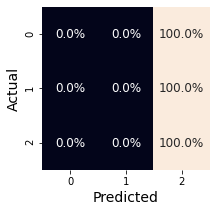

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro F1 Scores: 
 Training: 0.167 
 Testing: 0.256




In [67]:
visualization.confusion_heat_map(y_test,
                                 y_test_pred,
                                 normalize='true',
                                 fmt='.1%',
                                 labels=set(y_test))

f1_train, f1_test = metrics.f1_score(y_train, y_train_pred), metrics.f1_score(y_test, y_test_pred)

print("Macro F1 Scores: \n Training: {0:.3f} \n Testing: {1:.3f}\n\n".format(f1_train, f1_test))